# COMP7705 Project: (Re-)Imag(in)ing Price Trends

# GetData from local files (implemented additionally)


# Image Crop

In [1]:
import numpy as np
import os
from PIL import Image


!mkdir -p /kaggle/working/gooddata0705cropped/

image_dir = r'/kaggle/input/gooddata07051945/gooddata0705/'
output_dir = r'/kaggle/working/gooddata0705cropped/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

file_list = os.listdir(image_dir)
image_list = [i for i in file_list if i.endswith('.png')]
image_list.sort()

for image_file in image_list:
    image_path = os.path.join(image_dir, image_file)
    output_path = os.path.join(output_dir, image_file)

    img = Image.open(image_path)
    cropped_img = img.crop((208, 71, 1037, 474))
    cropped_img.save(output_path)

print("Image cropping complete!")

Image cropping complete!


# Label generation (Return added)

In [2]:
!pip install yfinance

import pandas as pd
import os
import calendar
import yfinance as yf
from datetime import datetime, timedelta

image_dir = r"/kaggle/working/gooddata0705cropped/"
output_csv = r"/kaggle/working/gooddata0705cropped/labels.csv"

# Create an empty DataFrame to store the labels
labels_df = pd.DataFrame(columns=["Stock Code", "Year", "Week"])

# Iterate through the images in the directory
image_list = os.listdir(image_dir)
for image_file in image_list:
    if image_file.endswith('.png'):
        # Extract stock code, year, and week from the image filename
        stock_code, year, week = image_file.split("_")[1:4]
        week = week.replace(".png", "")

        # Format the week string with leading zero if necessary
        week_str = week if len(week) == 2 else f"0{week}"

        # Calculate the start and end dates based on the year and week number
        start_date = datetime.strptime(f"{year}-W{week_str}-1", "%Y-W%W-%w")
        end_date = start_date + timedelta(days=6)

        # Load the stock price data from Yahoo Finance
        data = yf.Ticker(stock_code).history(start=start_date, end=end_date)
        if data.empty:
            continue  # Skip to the next image if there is no data

        df = data.loc[:, ['Open', 'High', 'Low', 'Close', 'Volume']]
        df = df.rename_axis('Date')
        stock_data = df

        # Calculate the label based on the price change
        first_price = stock_data.iloc[0]["Close"]
        last_price = stock_data.iloc[-1]["Close"]
        label1 = 1 if last_price > first_price else 0
        label2 = (last_price-first_price)/first_price

        # Append the label to the DataFrame
        new_row = pd.DataFrame([{"Stock Code": stock_code, "Year": year, "Week": week, "Rise": label1, "Return": label2}])
        labels_df = pd.concat([labels_df, new_row], ignore_index=True)

# Save the labels to a CSV file
labels_df.to_csv(output_csv, index=False)

print("Label generation complete!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 29.5 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 4.3 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293634 sha256=891de0e2a4465da6668b6e778174814be736edce5a25923b30d1f40127e7ac75
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee
$000001.SS: possibly delisted; No price data found  (1d 2019-04-29 00:00:00 -> 2019-05-05 00:00:00)
$000001.SS: possibly delisted; No price data found  (1d 2019-02-04 00:00:00 -> 2019-02-10 00:00:00)
$399001.SZ: possibly delisted; No price data found  (1d 2019-04-29 00:00:00 -> 2019-05-05 00:00:00)
$^N225: possibly delisted; No price data found  (1d 2019-04-29 00:00:00 -> 2019-05-05 00:00:00)
$39900

# Data Preprocess （Return added, multiple stock separation）

In [4]:
import os
import pandas as pd
import numpy as np
from PIL import Image

# 假设有一个股票列表 stock_list
stock_list = ["^IBEX","^AXJO","^AORD","^NZ50","000001.SS","399001.SZ", "^HSI","^STI","^N225","^KS11","^IXIC","^GSPC","^DJI","IWM",\
               "^GSPTSE","^BVSP","^STOXX50E","^GDAXI", "^FTSE", "^FCHI"]  # 这里替换为您的股票列表

# 初始化三维数组来存储多个股票的数据
image_train_val_data = []
label_train_val_data = []
return_train_val_data = []
image_test_data = []
label_test_data = []
return_test_data = []

# 遍历股票列表
for stock_code in stock_list:
    # 指定图像文件夹和CSV文件路径
    image_dir = r"/kaggle/working/gooddata0705cropped/"
    csv_file = r"/kaggle/working/gooddata0705cropped/labels.csv"

    # 加载 CSV 数据
    data_df_original = pd.read_csv(csv_file)

    # 筛选特定股票的数据
    data_df_stock = data_df_original[data_df_original['Stock Code'] == stock_code]

    # 按时间排序
    data_df = data_df_stock.sort_values(['Year', 'Week'])

    # 创建空列表以存储图像数据、标签和收益率
    image_data = []
    labels = []
    returns = []

    # 遍历 CSV 行
    for index, row in data_df.iterrows():
        year = row["Year"]
        week = row["Week"]
        rise = row["Rise"]
        return_value = row["Return"]

        # 构造图像文件名
        image_filename = f"chart_{stock_code}_{year}_{week}.png"
        image_path = os.path.join(image_dir, image_filename)

        # 确保图像存在
        if os.path.exists(image_path):
            # 打开并调整图像大小，转换为灰度格式
            image = Image.open(image_path).resize((207, 101)).convert('L')
            image_array = np.array(image)

            # 添加图像数据、标签和收益率到列表
            image_data.append(image_array)
            labels.append(rise)
            returns.append(return_value)

    # 将列表转换为 NumPy 数组
    image_data = np.array(image_data)
    labels = np.array(labels)
    returns = np.array(returns)

    # 划分数据为训练集和测试集（80:20 比例）
    split_ratio = 0.8
    split_index = int(len(image_data) * split_ratio)

    # 训练集和验证集
    image_train_val, image_test = image_data[:split_index], image_data[split_index:]
    label_train_val, label_test = labels[:split_index], labels[split_index:]
    return_train_val, return_test = returns[:split_index], returns[split_index:]

    # 将当前股票的数据添加到三维数组中
    image_train_val_data.append(image_train_val)
    label_train_val_data.append(label_train_val)
    return_train_val_data.append(return_train_val)
    image_test_data.append(image_test)
    label_test_data.append(label_test)
    return_test_data.append(return_test)

    # 打印数据集形状信息
    print(f"股票 {stock_code} 数据集形状信息:")
    print("训练集图像:", image_train_val.shape)
    print("测试集图像:", image_test.shape)
    print("训练集标签:", label_train_val.shape)
    print("测试集标签:", label_test.shape)
    print("训练集收益率:", return_train_val.shape)
    print("测试集收益率:", return_test.shape)

# 现在 image_train_val_data, label_train_val_data, return_train_val_data, 
# image_test_data, label_test_data, return_test_data 包含了所有股票的三维数组数据

股票 ^IBEX 数据集形状信息:
训练集图像: (198, 101, 207)
测试集图像: (50, 101, 207)
训练集标签: (198,)
测试集标签: (50,)
训练集收益率: (198,)
测试集收益率: (50,)
股票 ^AXJO 数据集形状信息:
训练集图像: (198, 101, 207)
测试集图像: (50, 101, 207)
训练集标签: (198,)
测试集标签: (50,)
训练集收益率: (198,)
测试集收益率: (50,)
股票 ^AORD 数据集形状信息:
训练集图像: (198, 101, 207)
测试集图像: (50, 101, 207)
训练集标签: (198,)
测试集标签: (50,)
训练集收益率: (198,)
测试集收益率: (50,)
股票 ^NZ50 数据集形状信息:
训练集图像: (198, 101, 207)
测试集图像: (50, 101, 207)
训练集标签: (198,)
测试集标签: (50,)
训练集收益率: (198,)
测试集收益率: (50,)
股票 000001.SS 数据集形状信息:
训练集图像: (191, 101, 207)
测试集图像: (48, 101, 207)
训练集标签: (191,)
测试集标签: (48,)
训练集收益率: (191,)
测试集收益率: (48,)
股票 399001.SZ 数据集形状信息:
训练集图像: (191, 101, 207)
测试集图像: (48, 101, 207)
训练集标签: (191,)
测试集标签: (48,)
训练集收益率: (191,)
测试集收益率: (48,)
股票 ^HSI 数据集形状信息:
训练集图像: (198, 101, 207)
测试集图像: (50, 101, 207)
训练集标签: (198,)
测试集标签: (50,)
训练集收益率: (198,)
测试集收益率: (50,)
股票 ^STI 数据集形状信息:
训练集图像: (198, 101, 207)
测试集图像: (50, 101, 207)
训练集标签: (198,)
测试集标签: (50,)
训练集收益率: (198,)
测试集收益率: (50,)
股票 ^N225 数据集形状信息:
训练集图像: (196, 101, 207)
测

In [5]:
print(len(image_train_val_data))

20


## Data EDA (Multiple stock separation)

In [6]:
data_df["Rise"] = data_df["Rise"].astype(int)
data_df.rename(columns={'Rise':'Label'},inplace=True)
data_df.tail(10)

,Stock Code,Year,Week,Label,Return
781,^FCHI,2019,43,1,0.005465
1213,^FCHI,2019,44,1,0.011229
4246,^FCHI,2019,45,1,0.007712
2054,^FCHI,2019,46,0,-0.006182
1202,^FCHI,2019,47,0,-0.003323
601,^FCHI,2019,48,1,0.014718
2866,^FCHI,2019,49,1,0.014008
3186,^FCHI,2019,50,1,0.004985
4014,^FCHI,2019,51,1,0.001330
3356,^FCHI,2019,52,1,0.010354


## CNN model (Multiple stock separation)

In [12]:
cold_start = True

if cold_start:
    # 遍历每个股票的数据
    for i, stock_data in enumerate(image_train_val_data):
        # 将255替换为1
        stock_data[stock_data == 255] = 1

        # 划分训练集和验证集
        split_index = int(0.7 * len(stock_data))

        # 保存数据到文件，为每个股票的数据创建独立的文件
        np.save(f'train_x_{i}.npy', stock_data[:split_index])
        np.save(f'train_y_{i}.npy', label_train_val_data[i][:split_index])
        np.save(f'val_x_{i}.npy', stock_data[split_index:])
        np.save(f'val_y_{i}.npy', label_train_val_data[i][split_index:])

    # 对测试数据执行相同的255替换操作
    for i, test_data in enumerate(image_test_data):
        test_data[test_data == 255] = 1
        # 保存测试数据到文件，为每个股票的测试数据创建独立的文件
        np.save(f'test_x_{i}.npy', test_data)
        np.save(f'test_y_{i}.npy', label_test_data[i])

print('.npy files for all stock codes generated successfully')

.npy files for all stock codes generated successfully


In [13]:
i = 0 # 挑股票查看
print(f'For certain stock code: {stock_list[i]}')
print("The size of training image is " + str(image_train_val_data[i][:split_index].shape))
print("The size of training label is " + str(label_train_val_data[i][:split_index].shape))
print("The size of validation image is " + str(image_train_val_data[i][split_index:].shape))
print("The size of validation label is " + str(label_train_val_data[i][split_index:].shape))
print("The size of testing image is " + str(image_test_data[i].shape))
print("The size of testing label is " + str(label_test_data[i].shape))

For certain stock code: ^IBEX
The size of training image is (138, 101, 207)
The size of training label is (138,)
The size of validation image is (60, 101, 207)
The size of validation label is (60,)
The size of testing image is (50, 101, 207)
The size of testing label is (50,)


In [14]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch

class ImageDataset(Dataset):
    def __init__(self, data_file_path, label_file_path, binary=True):
        self.data = np.load(data_file_path)
        self.label = np.load(label_file_path)
        self.binary = binary
    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        x = torch.from_numpy(x).float()
        x = x.unsqueeze(0)
        if self.binary:
            y = np.where(y > 0, 1, 0)
        y = torch.from_numpy(y).float()
        return x, y

    def __len__(self):
        return len(self.data)

class ImgDataset(Dataset):
    def __init__(self, data_file, label_file, binary=True):
        self.data = data_file
        self.label = label_file
        self.binary = binary
    def __getitem__(self, index):
        x = self.data[index]
        y = self.label[index]
        x = torch.from_numpy(x).float()
        x = x.unsqueeze(0)
        if self.binary:
            y = np.where(y > 0, 1, 0)
        y = torch.from_numpy(y).float()
        return x,y

    def __len__(self):
        return len(self.data)

In [15]:
import torch
from torch import nn
import torch.nn.functional as F
class ConvNet(nn.Module):
    """Encoder for feature embedding"""
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size=(5,3), padding=(0, 1), stride=(1,1) ,dilation=(4,1)),
                        nn.BatchNorm2d(64),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)))
        nn.init.xavier_uniform_(self.layer1[0].weight)
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,kernel_size=(5,3),padding=(0,1), stride=(1,1), dilation=(1,1)),
                        nn.BatchNorm2d(128),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)),)
        nn.init.xavier_uniform_(self.layer2[0].weight)
        self.layer3 = nn.Sequential(
                        nn.Conv2d(128,256,kernel_size=(5,3),padding=(0,1), stride=(1,1), dilation=(1,1)),
                        nn.BatchNorm2d(256),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)),)
        nn.init.xavier_uniform_(self.layer3[0].weight)
        self.layer4 = nn.Sequential(
                        nn.Conv2d(256,512,kernel_size=(5,3),padding=(0,1), stride=(1,1), dilation=(1,1)),
                        nn.BatchNorm2d(512),
                        nn.LeakyReLU(0.01),
                        nn.MaxPool2d(kernel_size  = (2, 1), stride=(2,1)),)
        nn.init.xavier_uniform_(self.layer4[0].weight)
        self.fc1 = nn.Sequential(
            nn.Linear(512*1*207, 2),
            nn.Dropout(p=0.5),
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.shape[0],-1)
        result = self.fc1(out)
        result = self.softmax(result)

        return result

def conv3():
    return ConvNet()

model = conv3()
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1), dilation=(4, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(5, 3), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), padding=0, dilation=1, ceil_mode=Fal

In [17]:
!pip install torchsummary
from torchsummary import summary
summary(model.to('cuda'), input_size=(1, 101, 207), device="cuda" )

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 64, 85, 207]           1,024
       BatchNorm2d-2          [-1, 64, 85, 207]             128
         LeakyReLU-3          [-1, 64, 85, 207]               0
         MaxPool2d-4          [-1, 64, 42, 207]               0
            Conv2d-5         [-1, 128, 38, 207]         123,008
       BatchNorm2d-6         [-1, 128, 38, 207]             256
         LeakyReLU-7         [-1, 128, 38, 207]               0
         MaxPool2d-8         [-1, 128, 19, 207]               0
            Conv2d-9         [-1, 256, 15, 207]         491,776
      BatchNorm2d-10         [-1, 256, 15, 207]             512
        LeakyReLU-11         [-1, 256, 15, 207]               0
        MaxPool2d-12          [-1, 256, 7, 207]               0
           Conv2d-13          [-1, 512, 3, 207]       1,966,592
      BatchNorm2d-14          [-1, 512,

# Function of measurement

In [18]:
import torch
import numpy as np
import random
import os
from copy import deepcopy
import math
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix

class Averager():

    def __init__(self):
        self.n = 0
        self.v = 0

    def add(self, x):
        self.v = (self.v * self.n + x) / (self.n + 1)
        self.n += 1

    def item(self):
        return self.v


def pretrain(model, loader, optimizer, device):
    model.train()
    ## training with ce
    loss_avg = Averager()
    for batch_idx, batch in enumerate(loader):
        model.zero_grad()
        optimizer.zero_grad()
        train_inputs, train_targets = batch[0], batch[1]
        train_targets = train_targets.long()
        train_inputs = train_inputs.to(device=device)
        train_targets = train_targets.to(device=device)
        train_logits = model(train_inputs)
        loss = nn.CrossEntropyLoss()(train_logits, train_targets)
        loss_avg.add(loss.item())
        loss.backward()
        optimizer.step()
    print("Train Loss %.4f" % (loss_avg.item()))
    return loss_avg.item()

def evaluate_batch(model, data_loader, device):
    model.eval()
    correct = num = 0
    for iter, pack in enumerate(data_loader):
        data, target = pack[0].to(device), pack[1].to(device)
        targets = target.long()
        logits = model(data)
        _, pred = logits.max(1)
        correct += pred.eq(target).sum().item()
        num += data.shape[0]
    torch.cuda.empty_cache()
    model.train()
    return correct/num 


def get_confusion(model, data_loader, device):
    model.eval()
    correct = num = 0
    y_true = []
    y_pred = []
    for iter, pack in enumerate(data_loader):
        data, target = pack[0].to(device), pack[1].to(device)
        targets = target.long()
        logits = model(data)
        _, pred = logits.max(1)
        y_true.append(target.item())
        y_pred.append(pred.item())
        correct += pred.eq(target).sum().item()
        num += data.shape[0]
    torch.cuda.empty_cache()
#     print(y_true)
#     print(y_pred)
    model.train()
    return confusion_matrix(y_true, y_pred)

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
# 绘制混淆矩阵
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Input
    - cm : 计算出的混淆矩阵的值
    - classes : 混淆矩阵中每一行每一列对应的列
    - normalize : True:显示百分比, False:显示个数
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Single Stock Strategy Long and Close
# Single Stock Strategy Long and Short
# Portfolio Strategy Equal Weighted Long and Close 
# (Cumulative Return, Annualized Return, Sharpe Ratio...)

50
Stock code:^IBEX


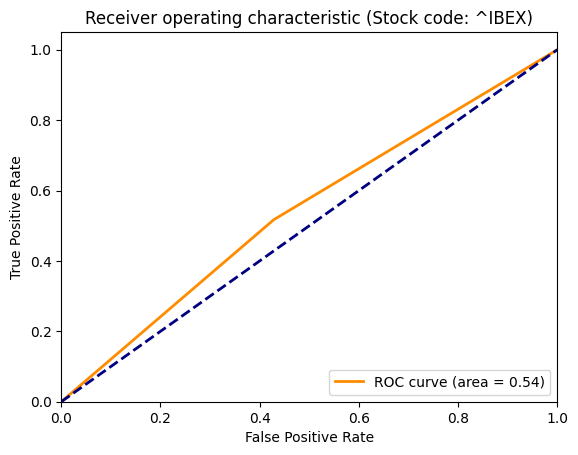

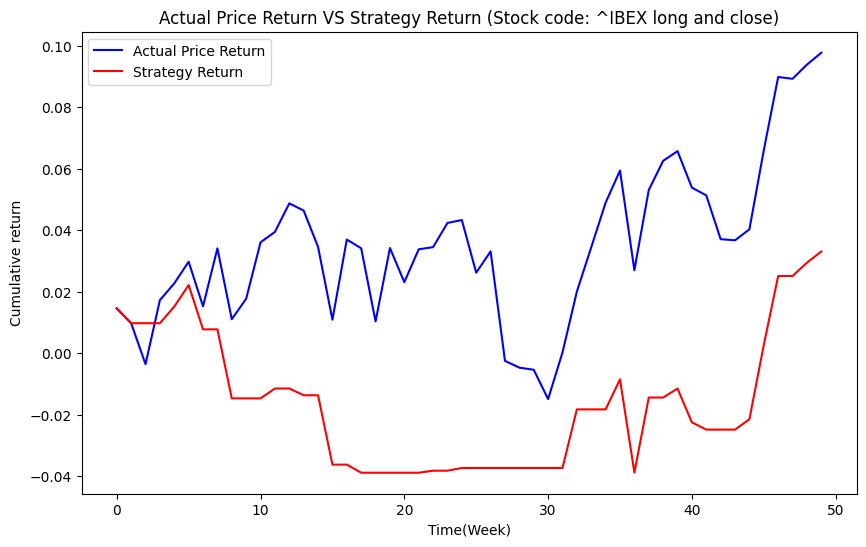

Long and close----------------------
Final cumulative return: 3.30%
Annualized return: 3.44%
Annualized_volatility: 7.13%
Sharpe Ratio: 0.48



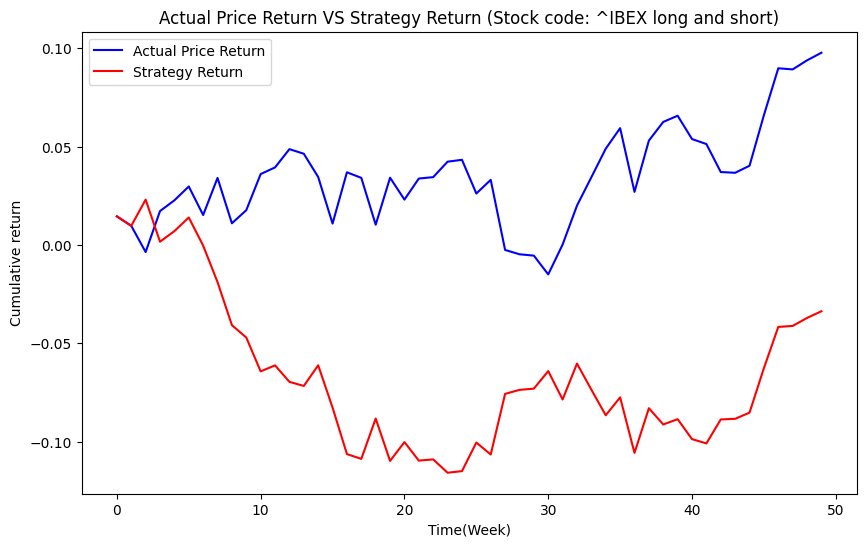

Long and short----------------------
Final cumulative return: -3.37%
Annualized return: -3.50%
Annualized_volatility: 10.68%
Sharpe Ratio: -0.33

Stock code:^AXJO


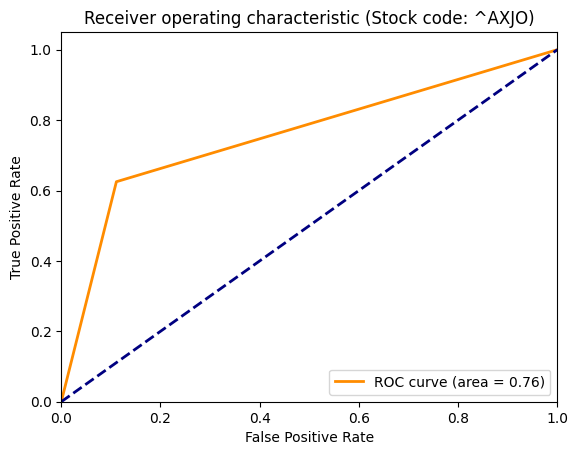

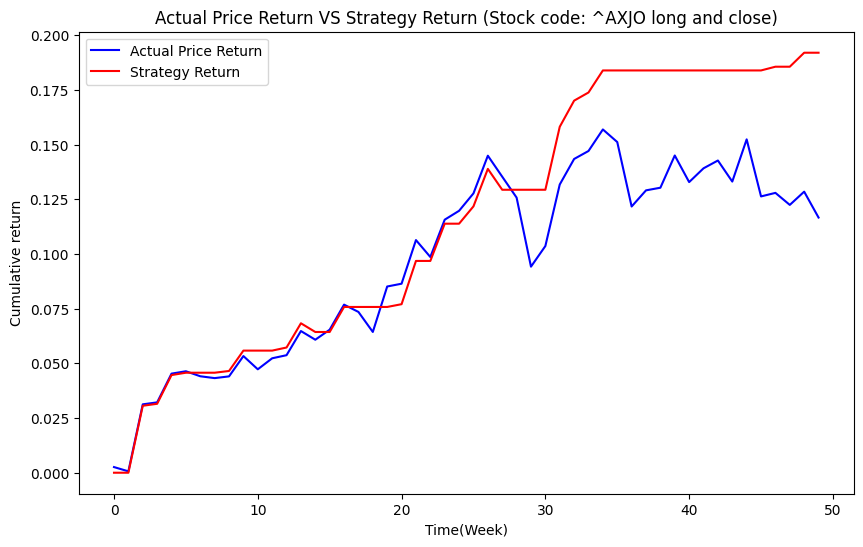

Long and close----------------------
Final cumulative return: 19.20%
Annualized return: 20.04%
Annualized_volatility: 5.20%
Sharpe Ratio: 3.86



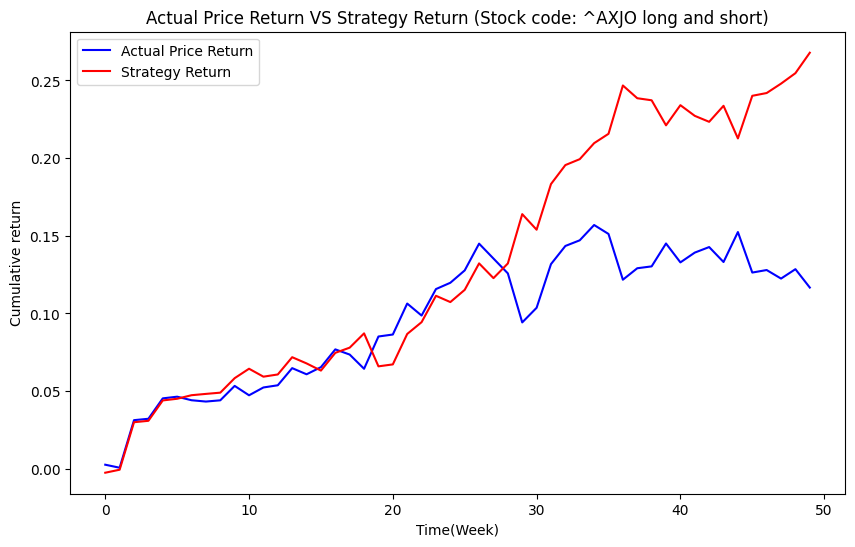

Long and short----------------------
Final cumulative return: 26.78%
Annualized return: 27.99%
Annualized_volatility: 7.68%
Sharpe Ratio: 3.65

Stock code:^AORD


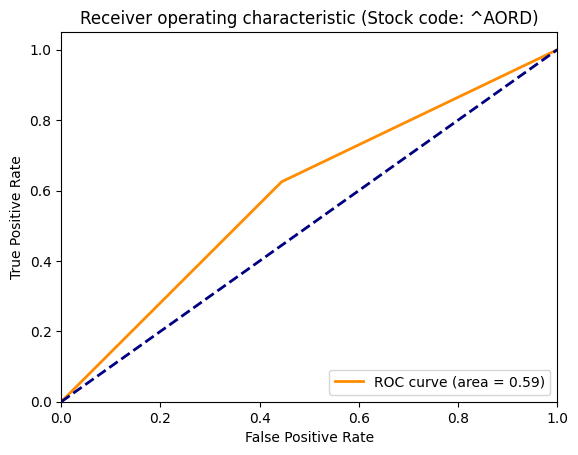

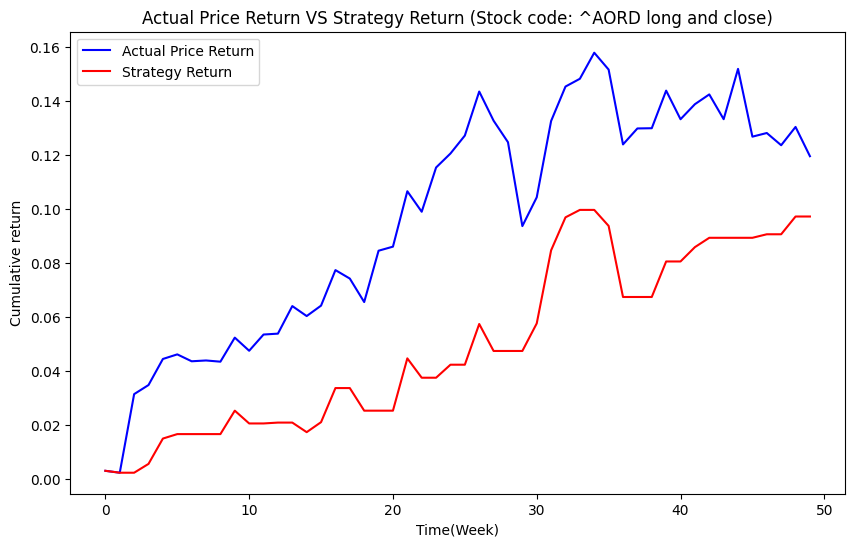

Long and close----------------------
Final cumulative return: 9.71%
Annualized return: 10.12%
Annualized_volatility: 5.31%
Sharpe Ratio: 1.91



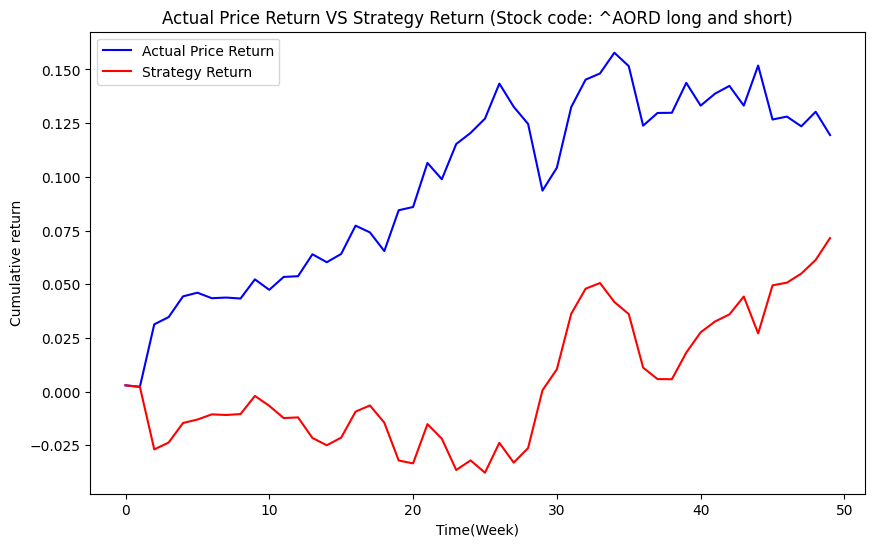

Long and short----------------------
Final cumulative return: 7.15%
Annualized return: 7.45%
Annualized_volatility: 8.07%
Sharpe Ratio: 0.92

Stock code:^NZ50


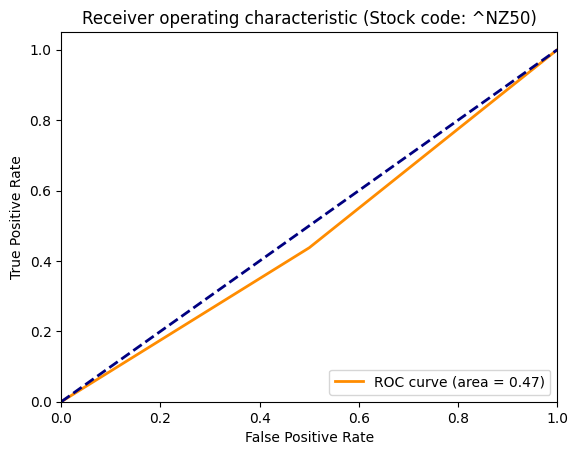

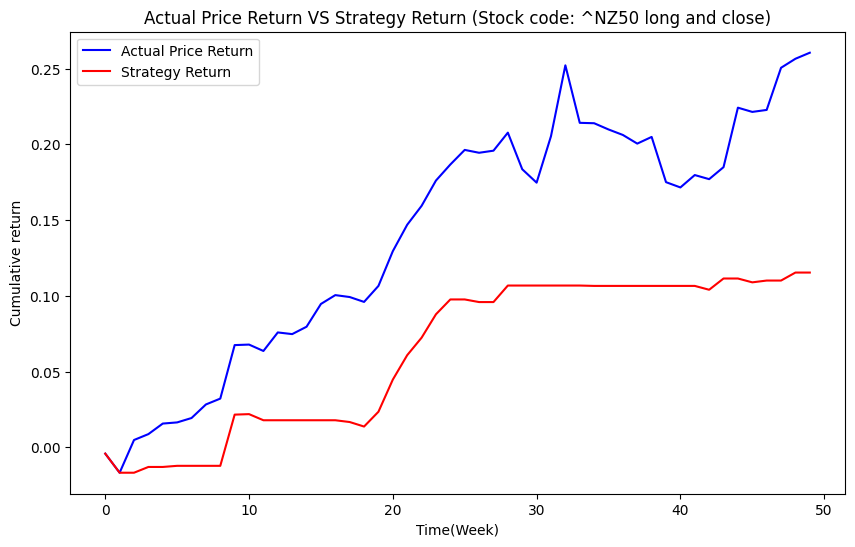

Long and close----------------------
Final cumulative return: 11.53%
Annualized return: 12.02%
Annualized_volatility: 5.09%
Sharpe Ratio: 2.36



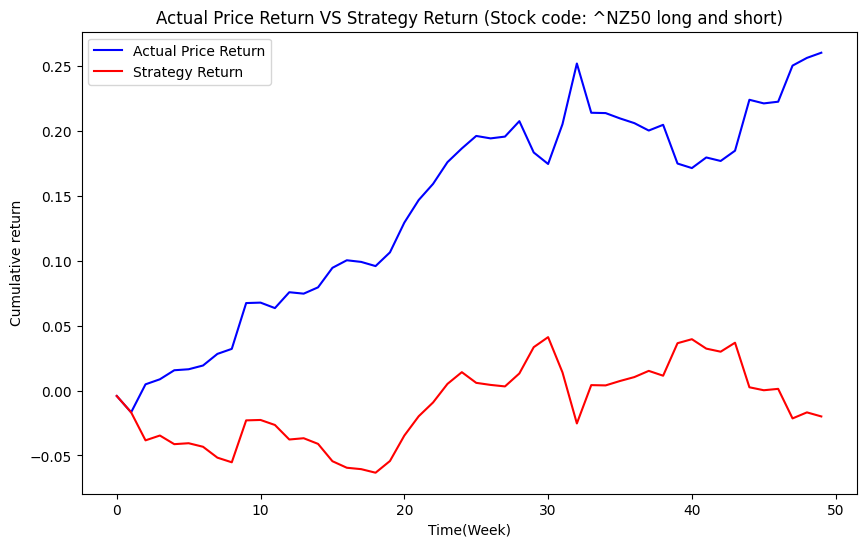

Long and short----------------------
Final cumulative return: -1.99%
Annualized return: -2.07%
Annualized_volatility: 10.05%
Sharpe Ratio: -0.21

Stock code:000001.SS


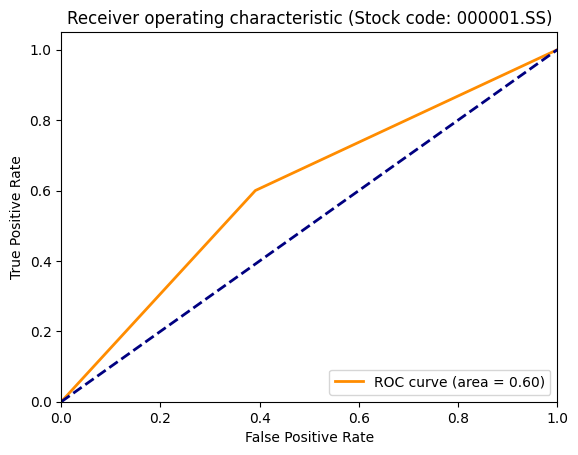

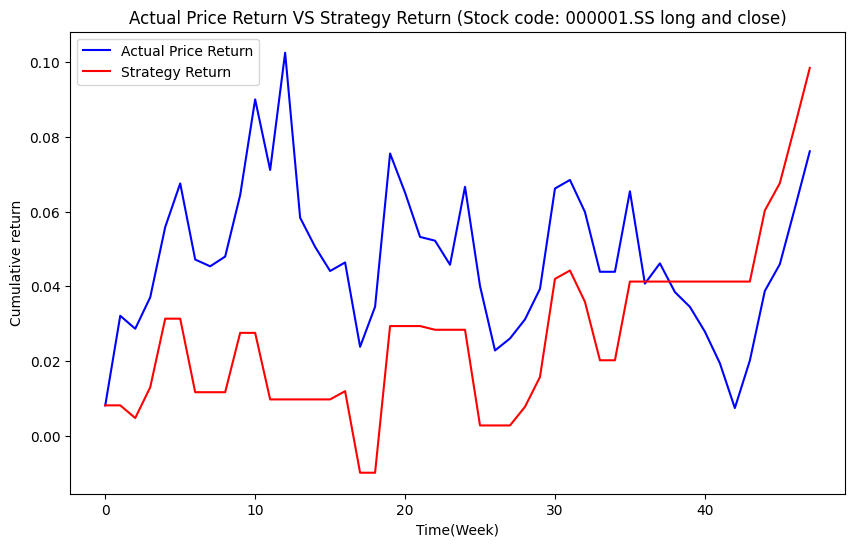

Long and close----------------------
Final cumulative return: 9.84%
Annualized return: 10.70%
Annualized_volatility: 8.14%
Sharpe Ratio: 1.32



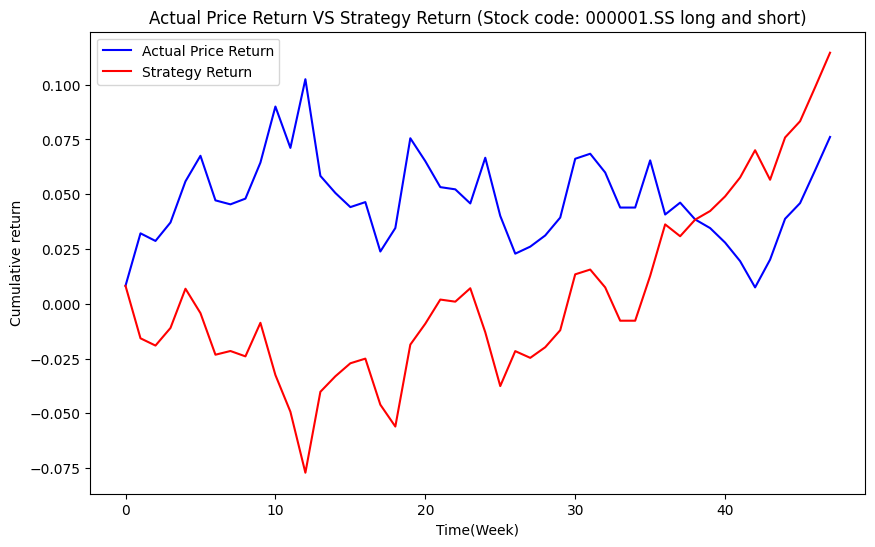

Long and short----------------------
Final cumulative return: 11.46%
Annualized return: 12.47%
Annualized_volatility: 11.37%
Sharpe Ratio: 1.10

Stock code:399001.SZ


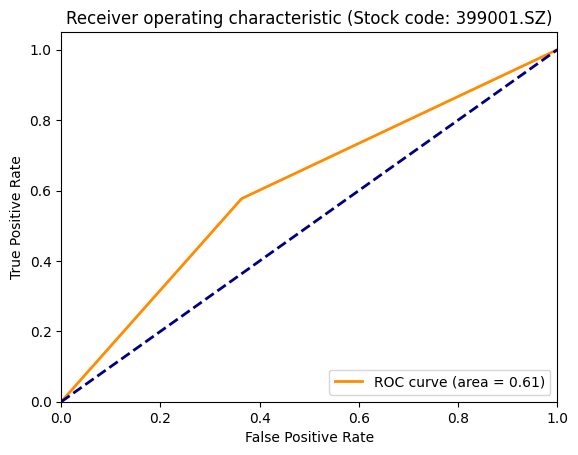

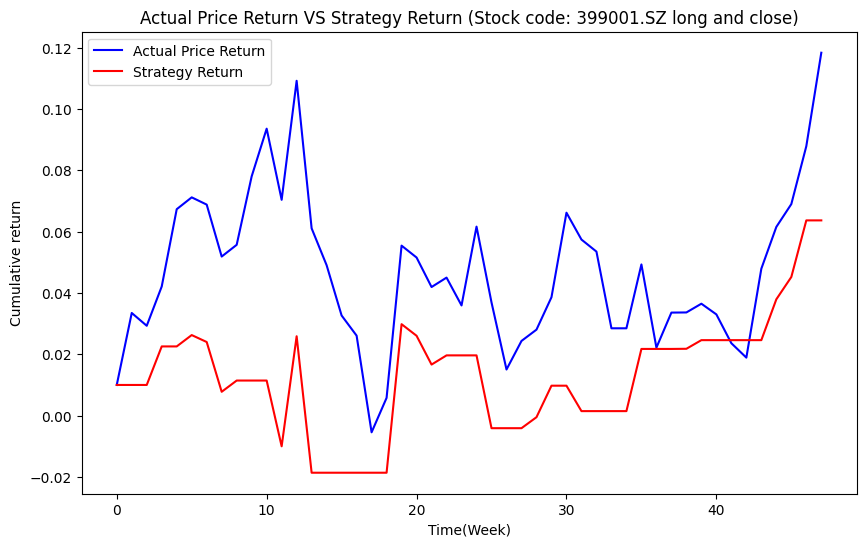

Long and close----------------------
Final cumulative return: 6.36%
Annualized return: 6.91%
Annualized_volatility: 9.49%
Sharpe Ratio: 0.73



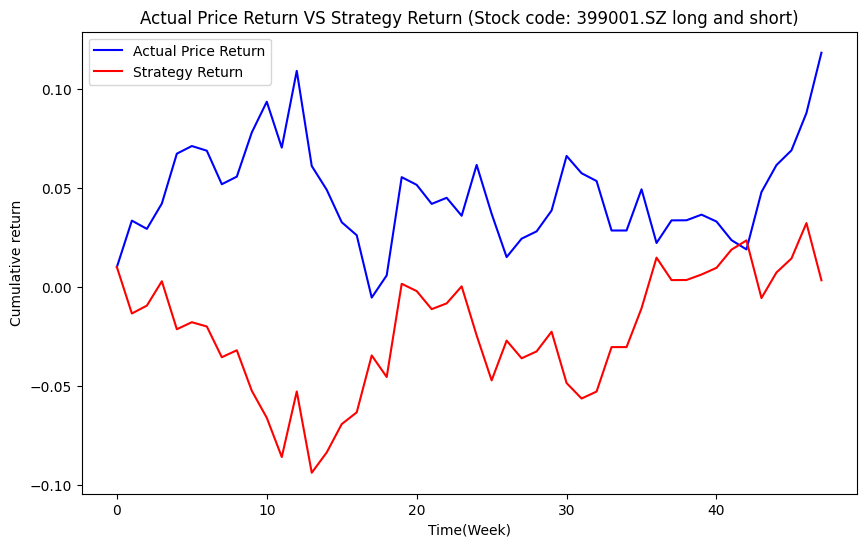

Long and short----------------------
Final cumulative return: 0.33%
Annualized return: 0.36%
Annualized_volatility: 13.44%
Sharpe Ratio: 0.03

Stock code:^HSI


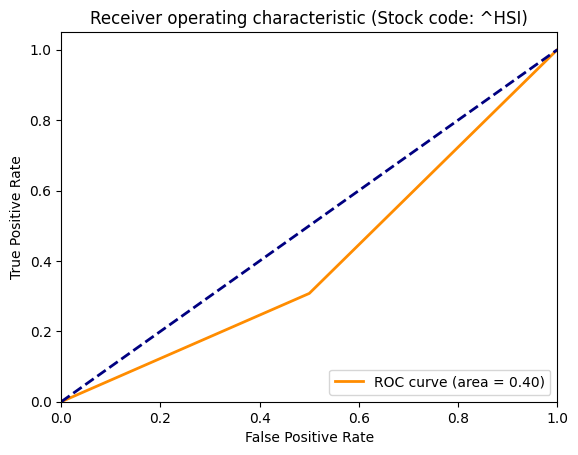

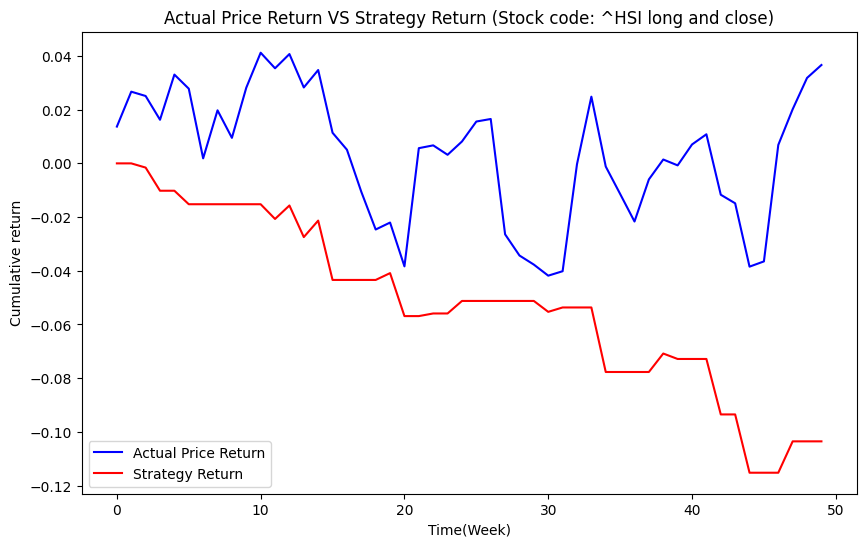

Long and close----------------------
Final cumulative return: -10.35%
Annualized return: -10.74%
Annualized_volatility: 5.49%
Sharpe Ratio: -1.96



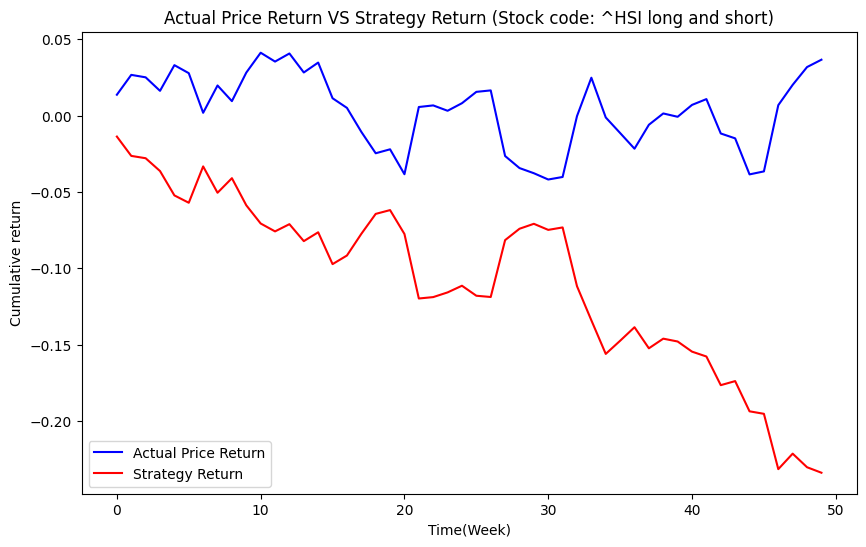

Long and short----------------------
Final cumulative return: -23.39%
Annualized return: -24.20%
Annualized_volatility: 11.89%
Sharpe Ratio: -2.04

Stock code:^STI


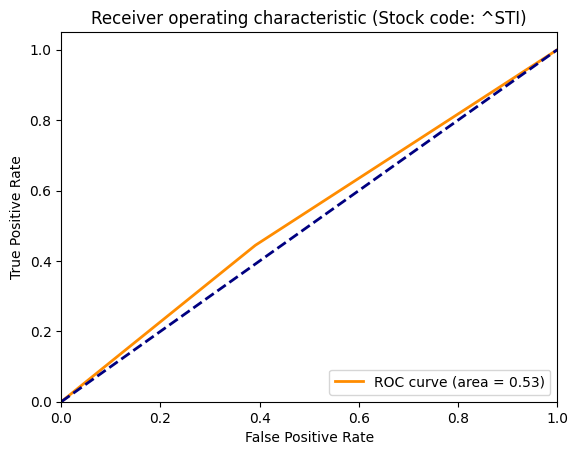

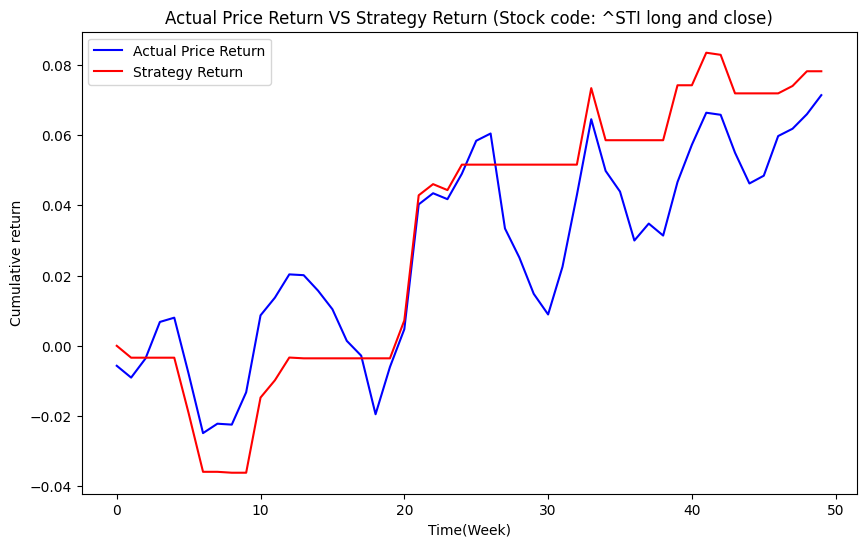

Long and close----------------------
Final cumulative return: 7.81%
Annualized return: 8.14%
Annualized_volatility: 5.99%
Sharpe Ratio: 1.36



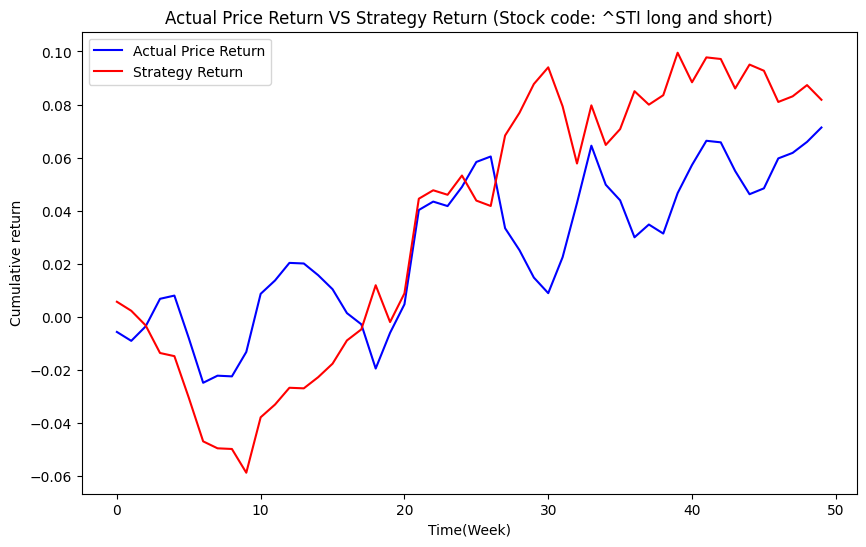

Long and short----------------------
Final cumulative return: 8.18%
Annualized return: 8.52%
Annualized_volatility: 8.15%
Sharpe Ratio: 1.04

Stock code:^N225


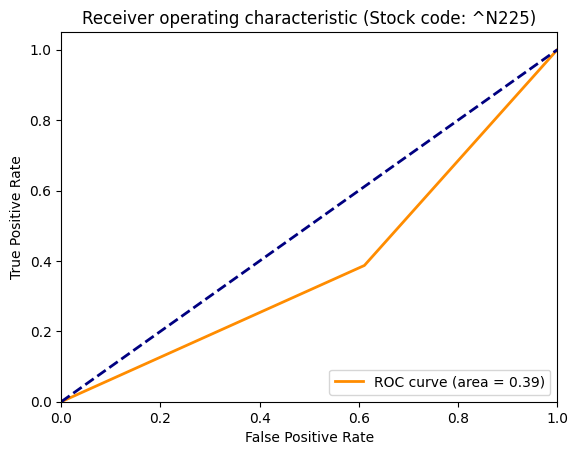

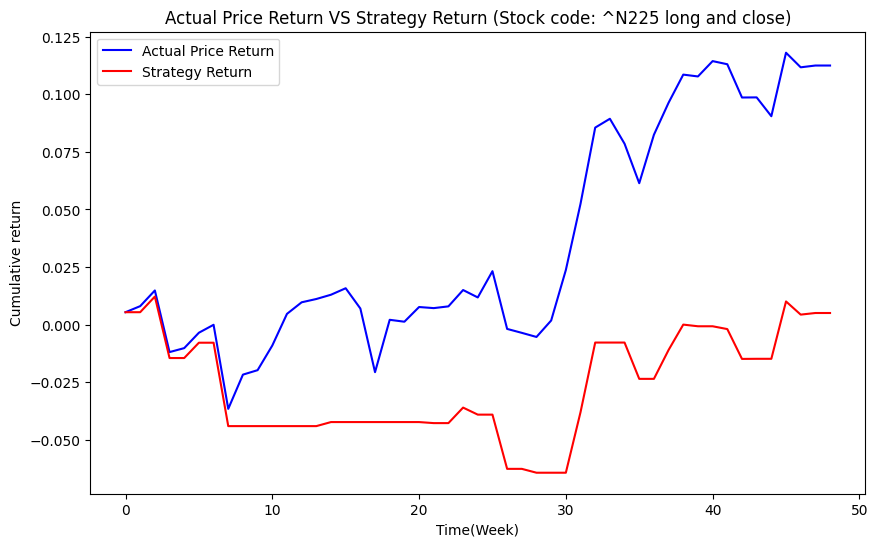

Long and close----------------------
Final cumulative return: 0.50%
Annualized return: 0.54%
Annualized_volatility: 7.96%
Sharpe Ratio: 0.07



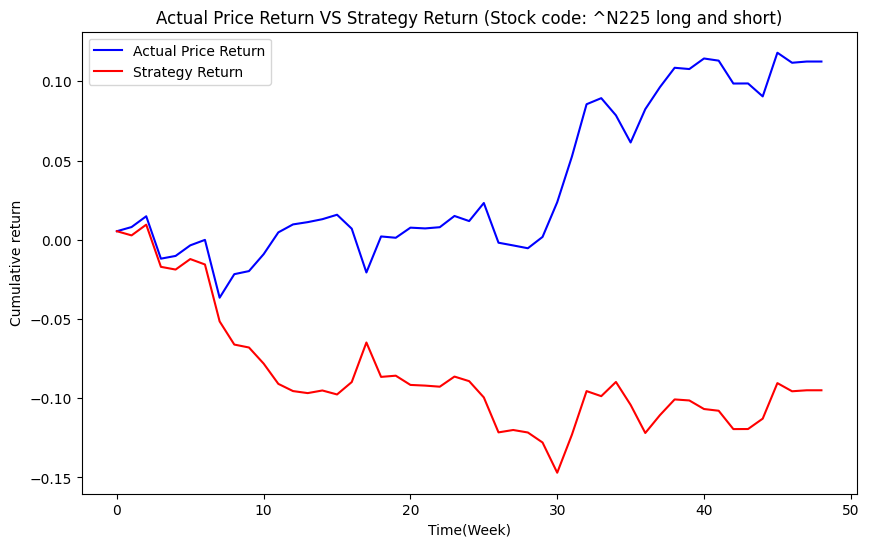

Long and short----------------------
Final cumulative return: -9.50%
Annualized return: -10.05%
Annualized_volatility: 9.81%
Sharpe Ratio: -1.02

Stock code:^KS11


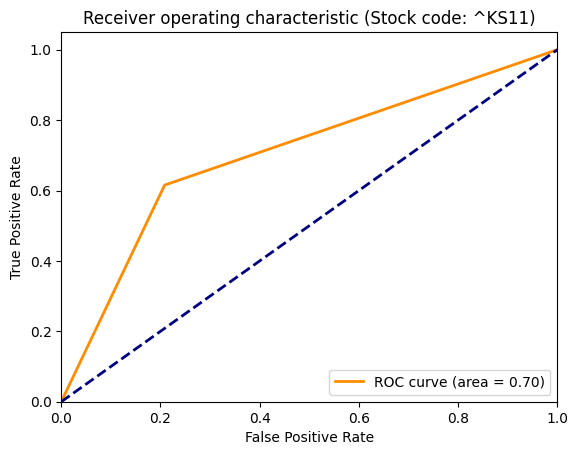

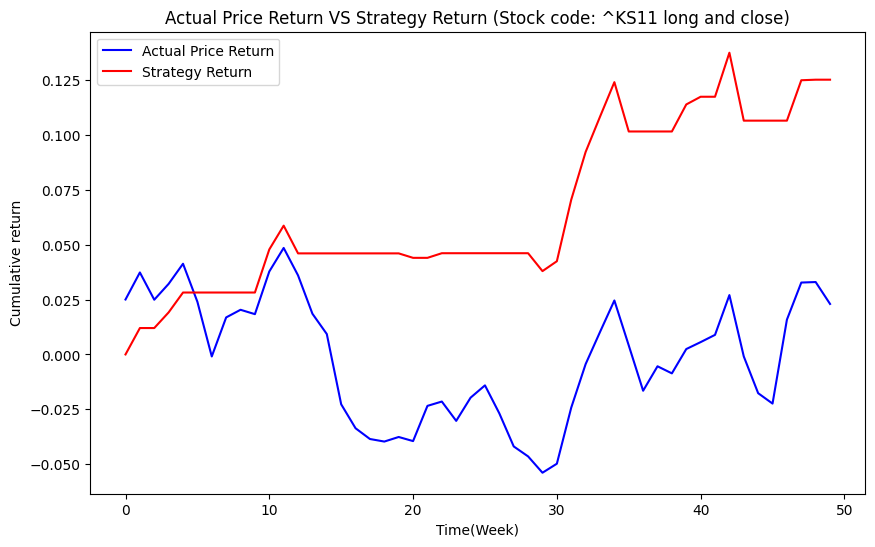

Long and close----------------------
Final cumulative return: 12.50%
Annualized return: 13.04%
Annualized_volatility: 6.53%
Sharpe Ratio: 2.00



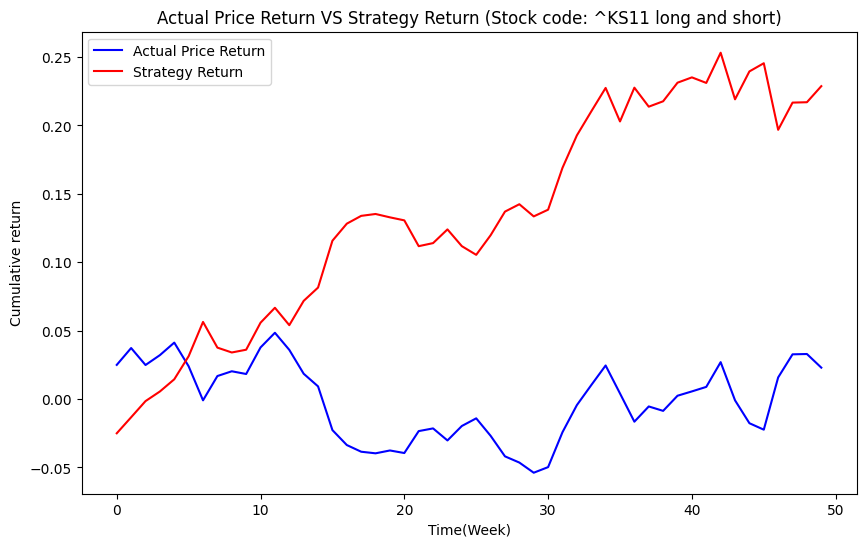

Long and short----------------------
Final cumulative return: 22.87%
Annualized return: 23.89%
Annualized_volatility: 10.41%
Sharpe Ratio: 2.29

Stock code:^IXIC


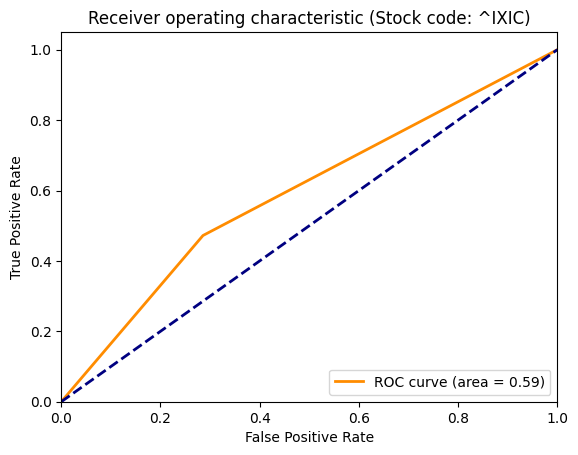

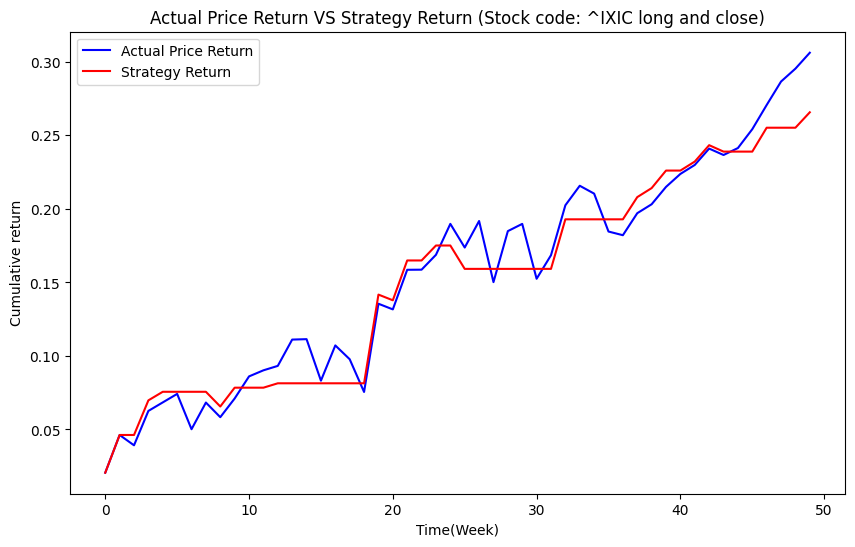

Long and close----------------------
Final cumulative return: 26.57%
Annualized return: 27.77%
Annualized_volatility: 7.98%
Sharpe Ratio: 3.48



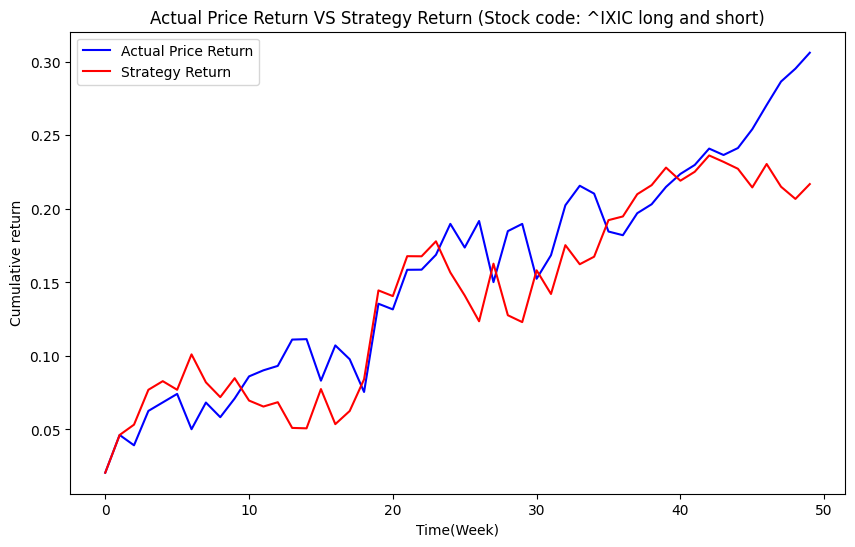

Long and short----------------------
Final cumulative return: 21.69%
Annualized return: 22.65%
Annualized_volatility: 12.18%
Sharpe Ratio: 1.86

Stock code:^GSPC


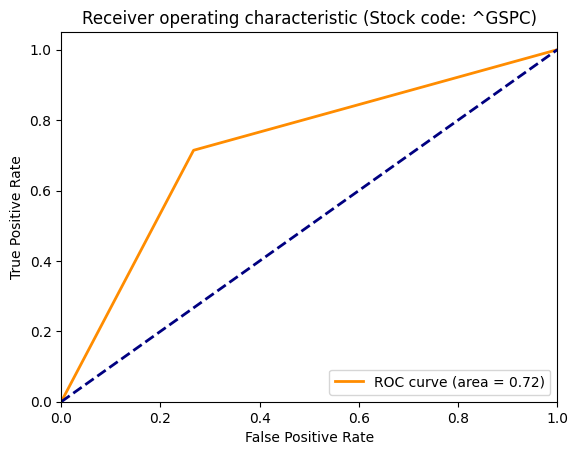

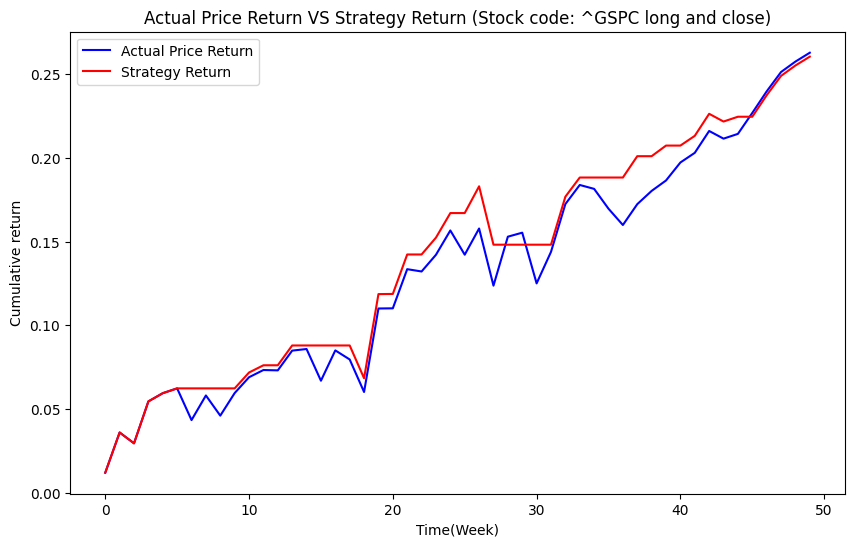

Long and close----------------------
Final cumulative return: 26.03%
Annualized return: 27.20%
Annualized_volatility: 7.90%
Sharpe Ratio: 3.44



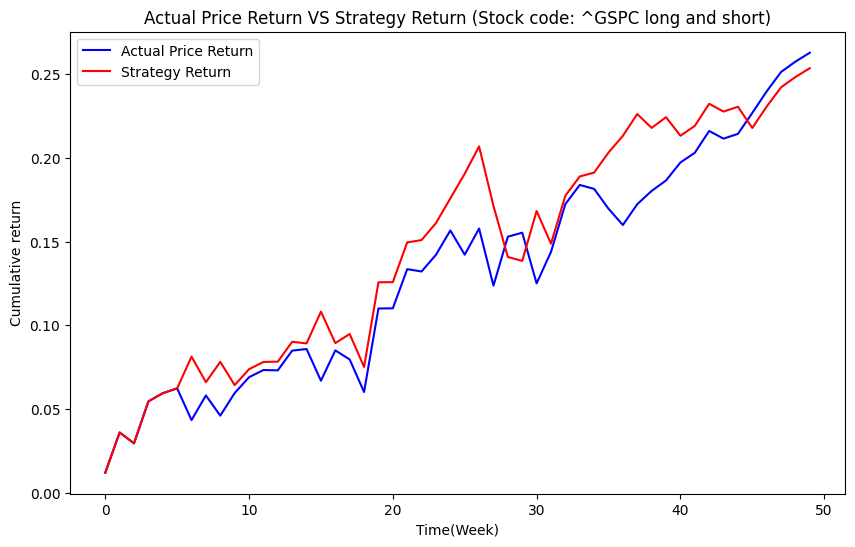

Long and short----------------------
Final cumulative return: 25.34%
Annualized return: 26.47%
Annualized_volatility: 10.03%
Sharpe Ratio: 2.64

Stock code:^DJI


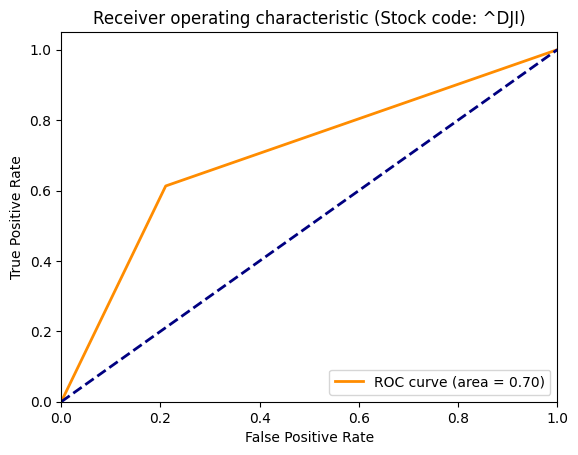

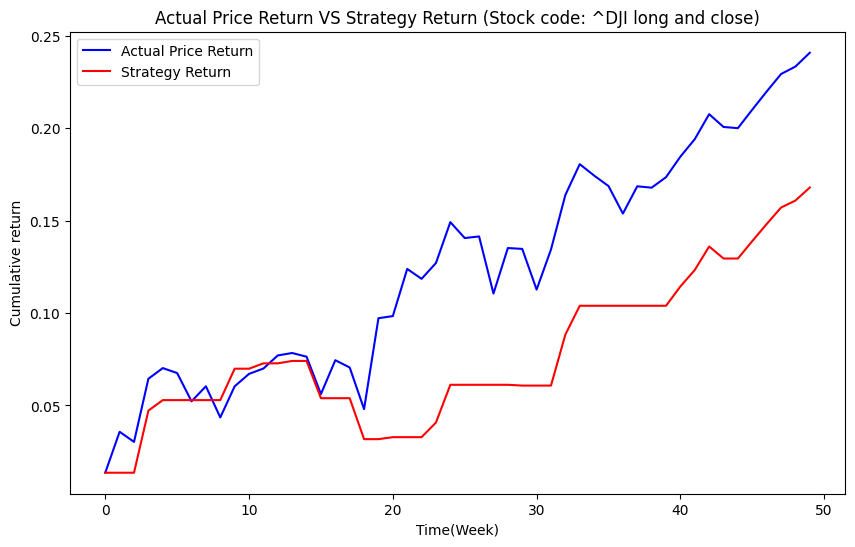

Long and close----------------------
Final cumulative return: 16.79%
Annualized return: 17.52%
Annualized_volatility: 6.26%
Sharpe Ratio: 2.80



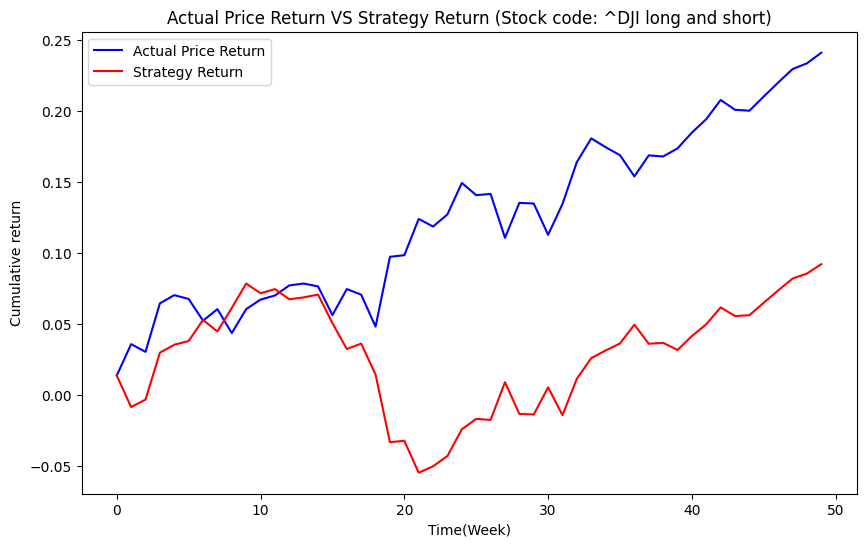

Long and short----------------------
Final cumulative return: 9.20%
Annualized return: 9.59%
Annualized_volatility: 10.56%
Sharpe Ratio: 0.91

Stock code:IWM


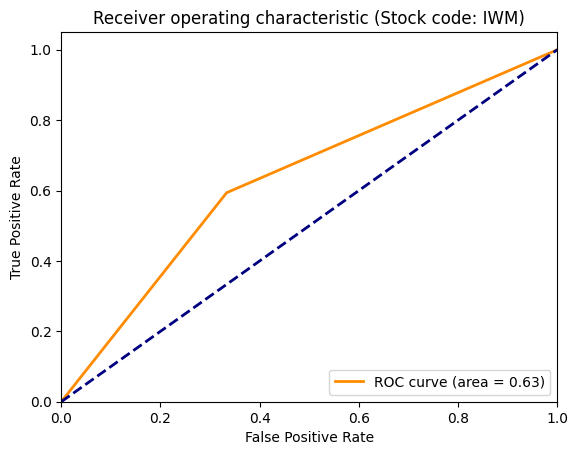

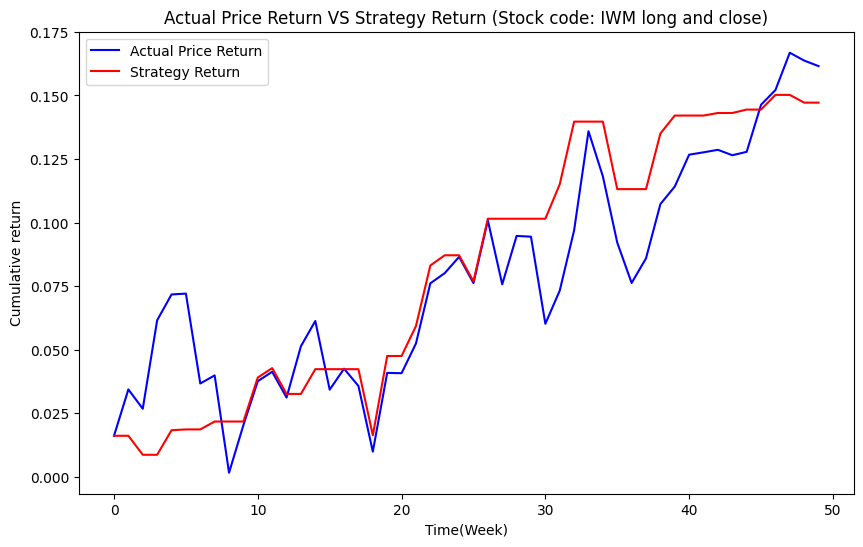

Long and close----------------------
Final cumulative return: 14.72%
Annualized return: 15.35%
Annualized_volatility: 7.19%
Sharpe Ratio: 2.13



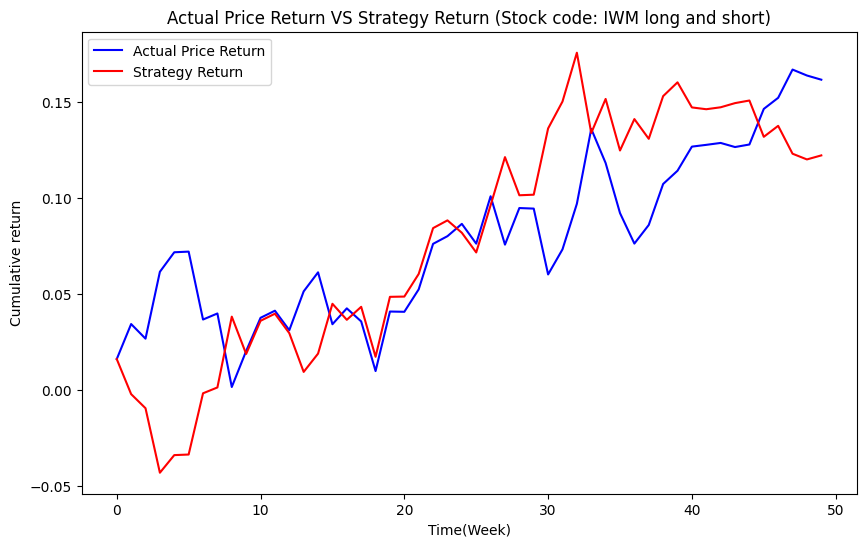

Long and short----------------------
Final cumulative return: 12.21%
Annualized return: 12.73%
Annualized_volatility: 12.36%
Sharpe Ratio: 1.03

Stock code:^GSPTSE


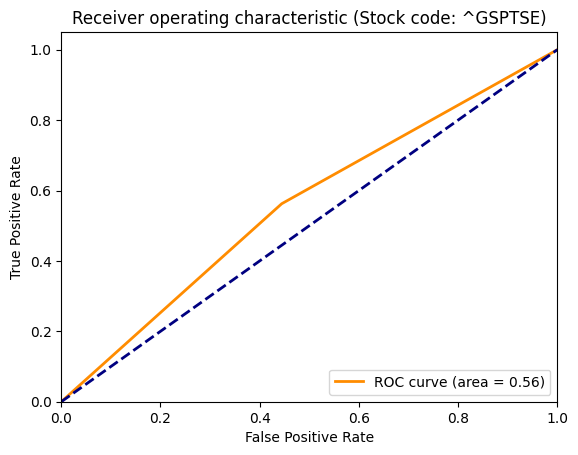

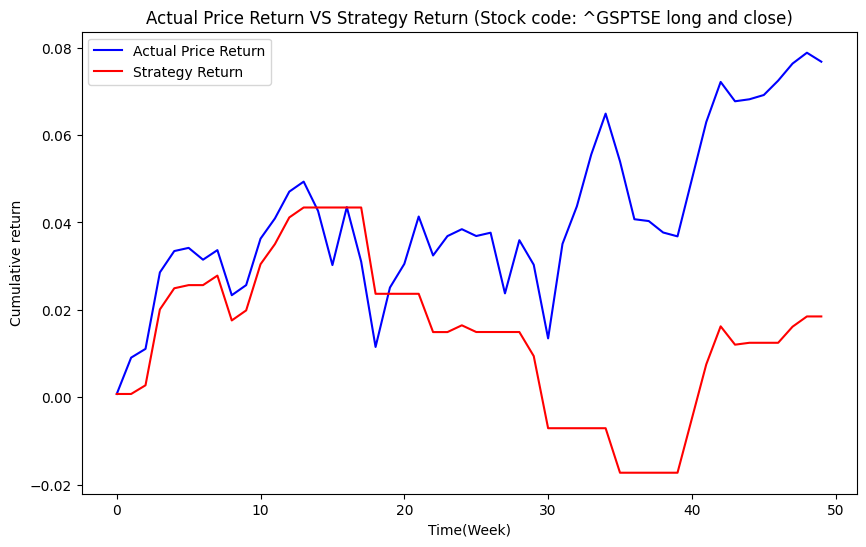

Long and close----------------------
Final cumulative return: 1.85%
Annualized return: 1.93%
Annualized_volatility: 4.39%
Sharpe Ratio: 0.44



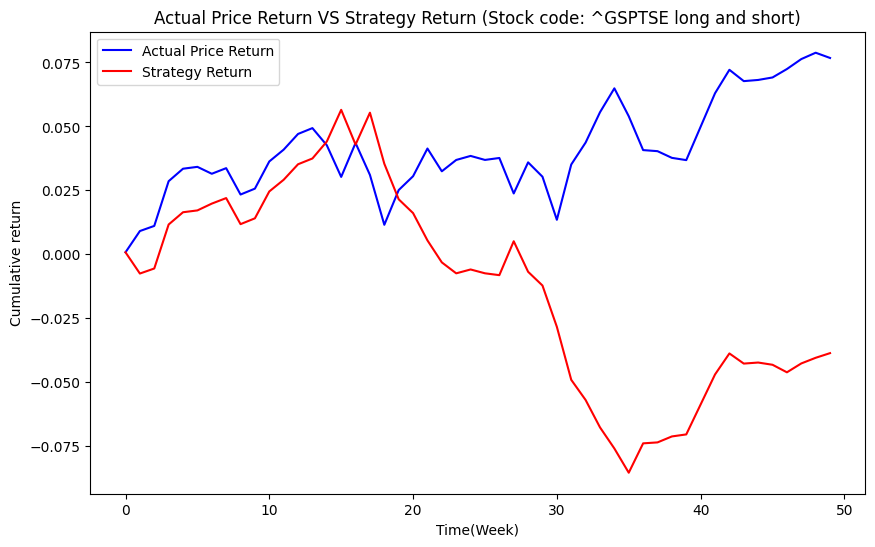

Long and short----------------------
Final cumulative return: -3.87%
Annualized return: -4.02%
Annualized_volatility: 6.43%
Sharpe Ratio: -0.63

Stock code:^BVSP


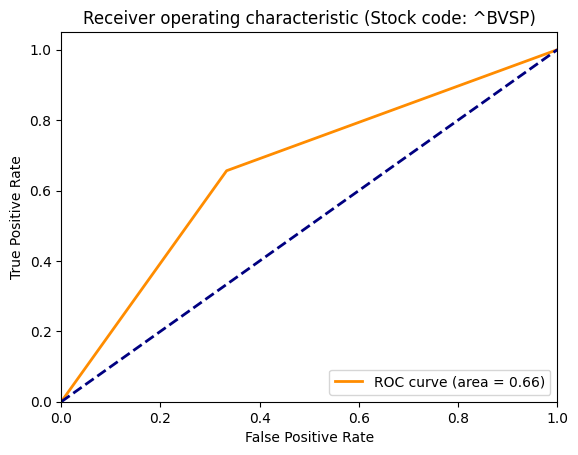

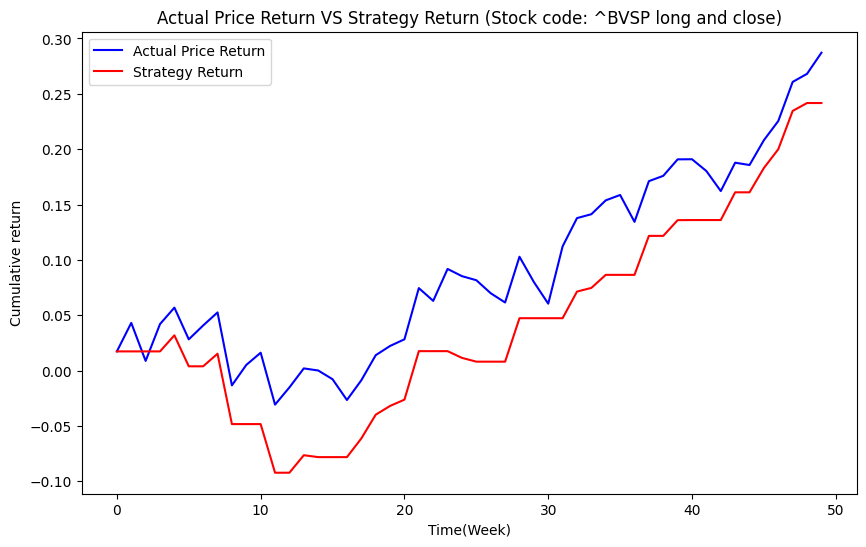

Long and close----------------------
Final cumulative return: 24.17%
Annualized return: 25.25%
Annualized_volatility: 12.51%
Sharpe Ratio: 2.02



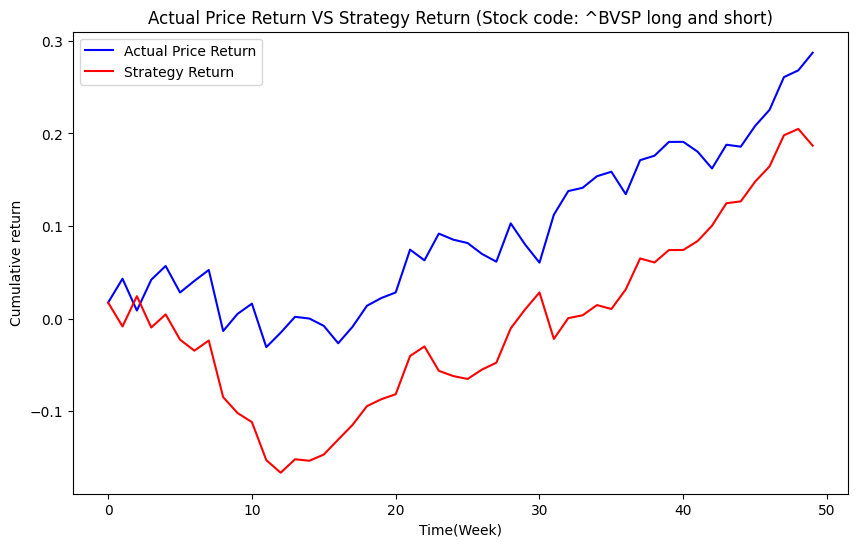

Long and short----------------------
Final cumulative return: 18.68%
Annualized return: 19.49%
Annualized_volatility: 16.02%
Sharpe Ratio: 1.22

Stock code:^STOXX50E


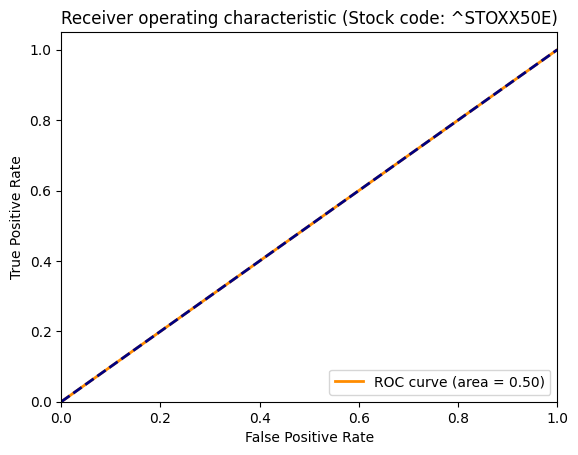

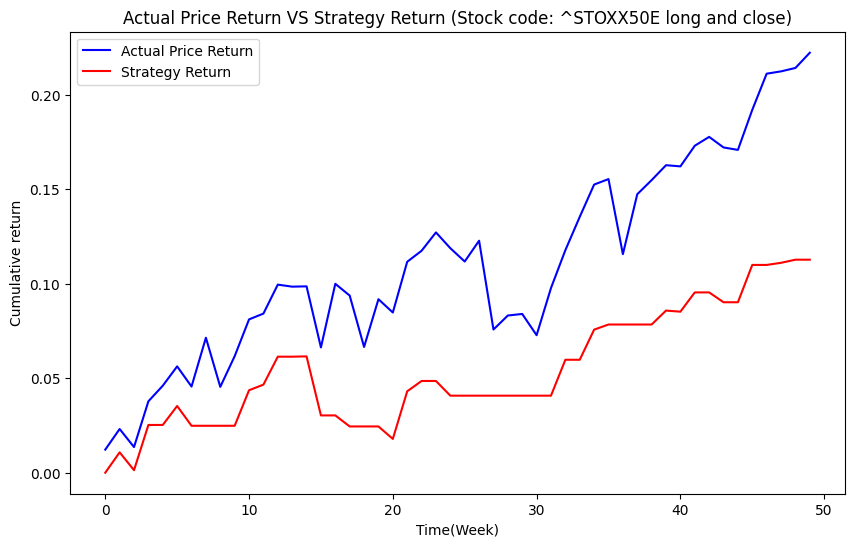

Long and close----------------------
Final cumulative return: 11.27%
Annualized return: 11.75%
Annualized_volatility: 6.42%
Sharpe Ratio: 1.83



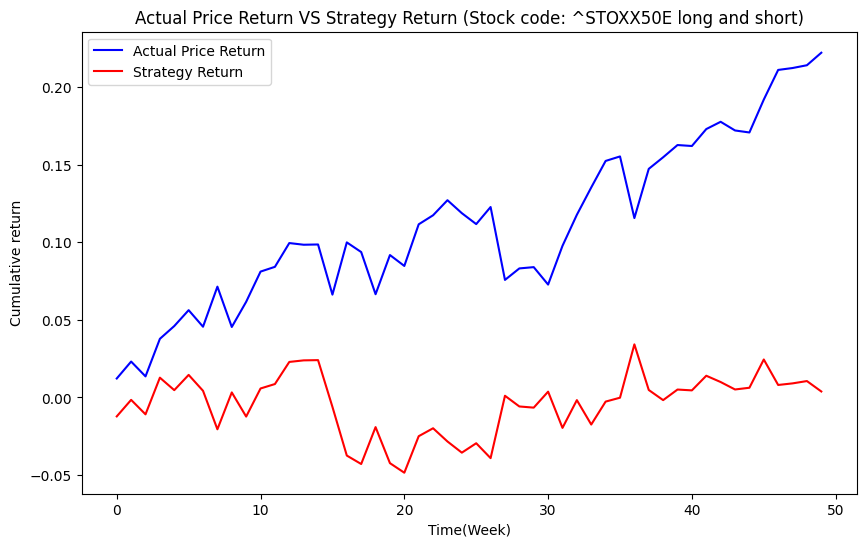

Long and short----------------------
Final cumulative return: 0.39%
Annualized return: 0.40%
Annualized_volatility: 11.76%
Sharpe Ratio: 0.03

Stock code:^GDAXI


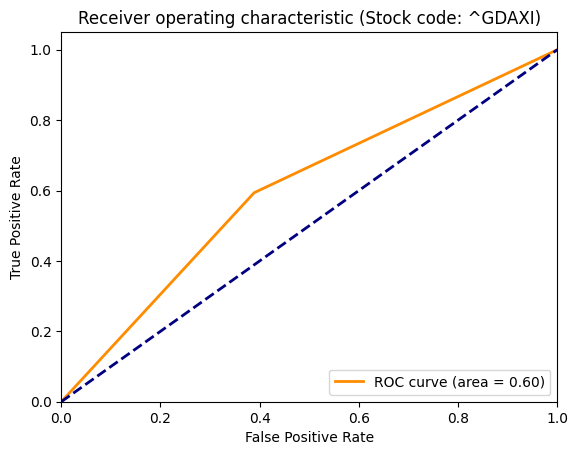

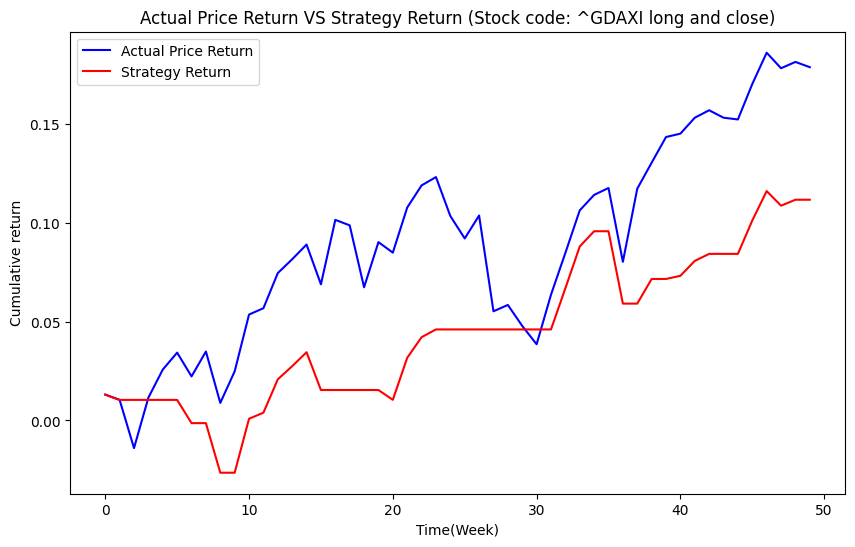

Long and close----------------------
Final cumulative return: 11.17%
Annualized return: 11.64%
Annualized_volatility: 7.52%
Sharpe Ratio: 1.55



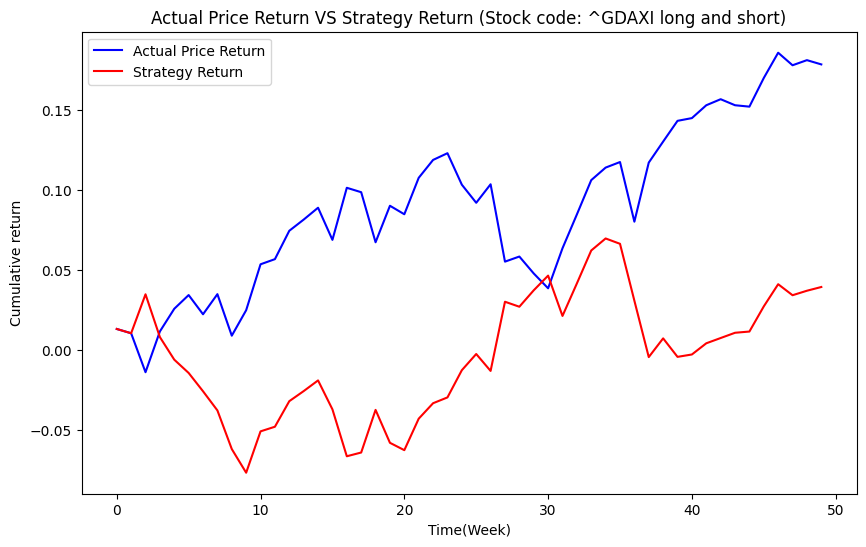

Long and short----------------------
Final cumulative return: 3.94%
Annualized return: 4.10%
Annualized_volatility: 12.20%
Sharpe Ratio: 0.34

Stock code:^FTSE


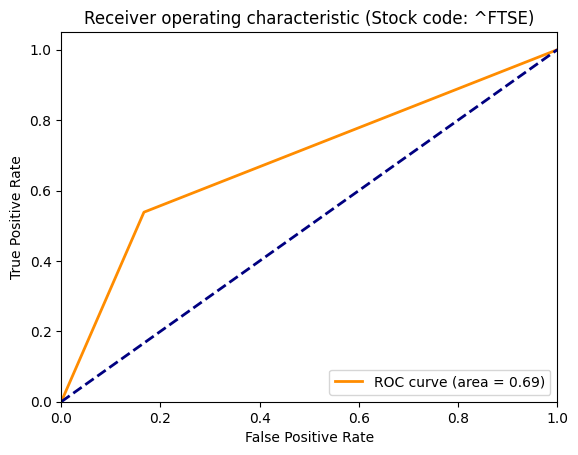

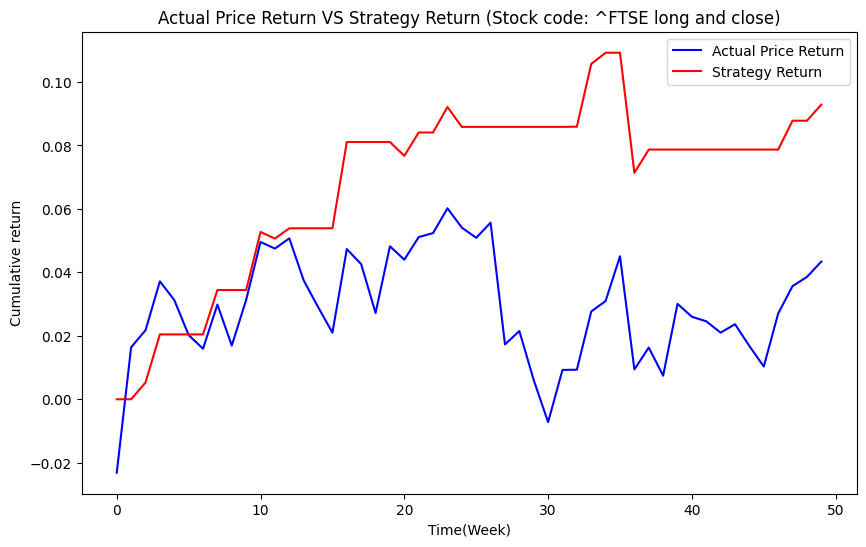

Long and close----------------------
Final cumulative return: 9.29%
Annualized return: 9.68%
Annualized_volatility: 5.65%
Sharpe Ratio: 1.71



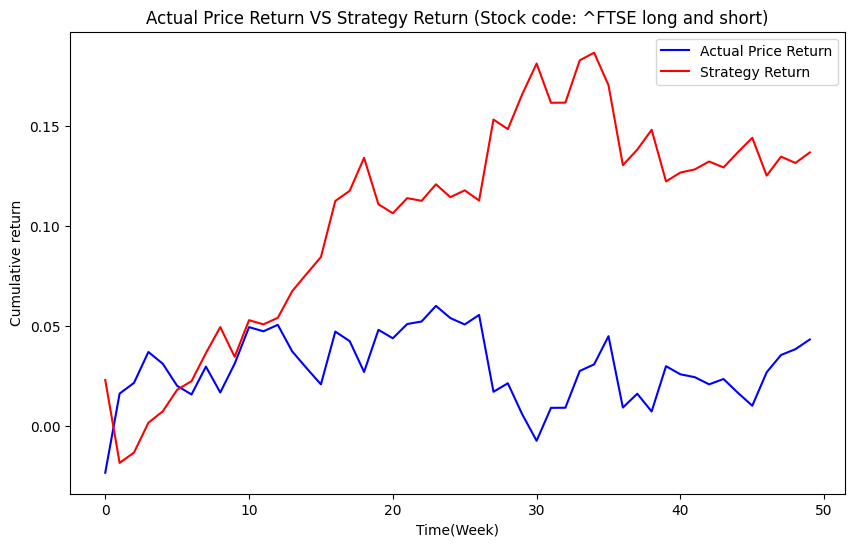

Long and short----------------------
Final cumulative return: 13.68%
Annualized return: 14.27%
Annualized_volatility: 10.06%
Sharpe Ratio: 1.42

Stock code:^FCHI


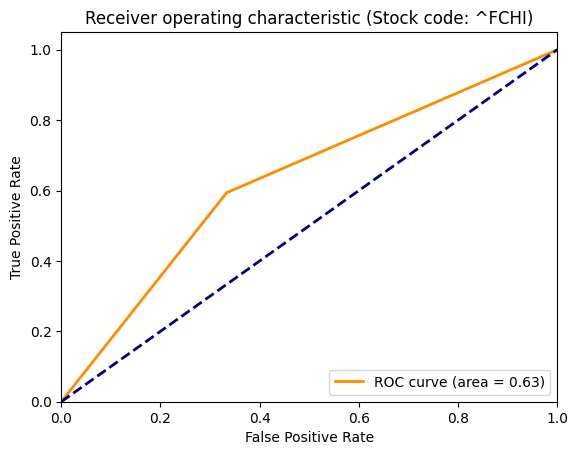

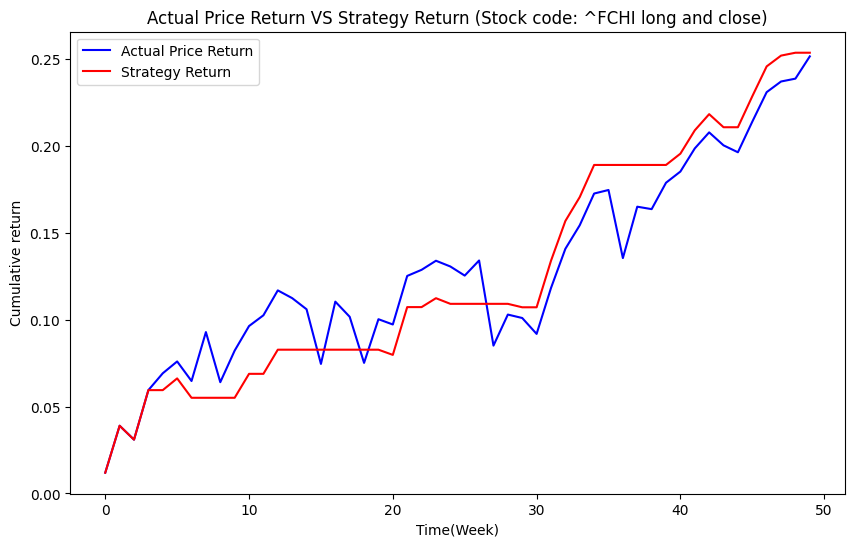

Long and close----------------------
Final cumulative return: 25.38%
Annualized return: 26.52%
Annualized_volatility: 6.36%
Sharpe Ratio: 4.17



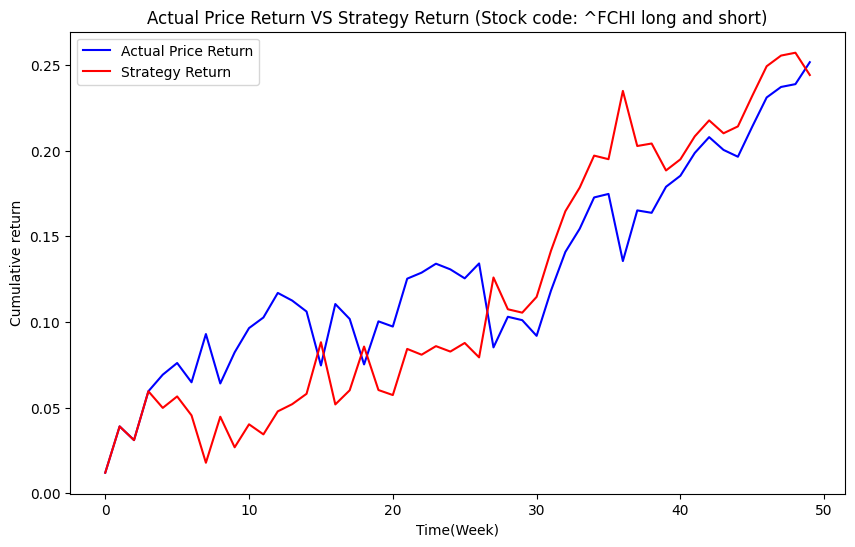

Long and short----------------------
Final cumulative return: 24.42%
Annualized return: 25.51%
Annualized_volatility: 11.75%
Sharpe Ratio: 2.17


Portfolio strategy measure of equal weighted long and close strategy (each stock 1 unit initial investment)-------------------------------------------------
Portfolio Cumulative Returns for whole test period: 12.04%
Portfolio Annualized Return: 12.55%
Portfolio Sharpe Ratio: 0.09


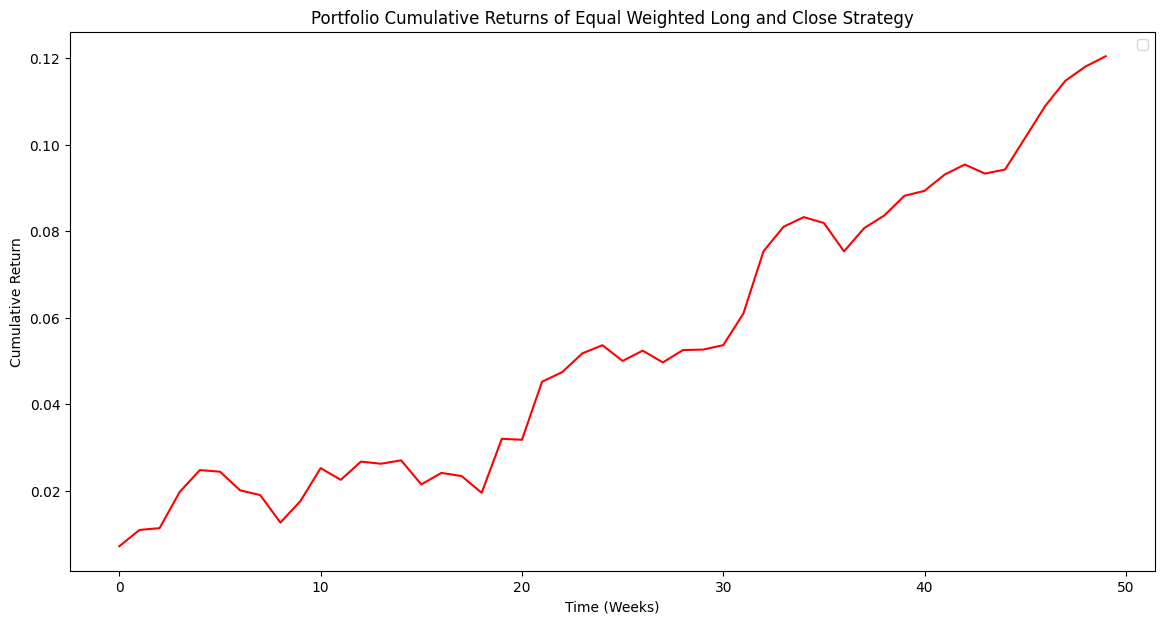

In [30]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

device = 'cuda'
model = conv3().cuda()

model.load_state_dict(torch.load('/kaggle/input/weight-lasttrained-0705/weight_lasttrained_0705.pth'))

# 计算所有股票的最长时间长度
max_length = max(len(data) for data in return_test_data)
print(max_length)

# 初始化投资组合累积收益数组和真实市场价格累积收益数组
portfolio_cumulative_returns = np.zeros(max_length)
portfolio_cumulative_actual_price_returns = np.zeros(max_length)
# print('portfolio_cumulative_returns shape:',portfolio_cumulative_returns.shape)

# 初始化每只股票的累积收益数组
cumulative_returns_per_stock = np.ones((len(stock_list), max_length))
# print('cumulative_returns_per_stock shape:',cumulative_returns_per_stock.shape)

# 初始化每只股票的每周收益数组和累计收益率
actual_price_returns_per_stock = np.zeros((len(stock_list), max_length))
cumulative_actual_price_returns_per_stock  = np.zeros((len(stock_list), max_length))

# 初始化投资组合的策略收益数组
portfolio_returns = np.zeros((max_length))

for i, stock_data in enumerate(image_test_data):
    testset = ImageDataset(f"test_x_{i}.npy",f"test_y_{i}.npy")
    batch_size = 1 # for testing
    test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=0,
                    pin_memory=True, drop_last=True)
    test_acc = evaluate_batch(model, test_loader, device)
    print(f'Stock code:{stock_list[i]}')
#     print('Test Acc : ', test_acc)
    test_matrix = get_confusion(model, test_loader, device)
    classes = ['Positive', 'Negative']

#     plot_confusion_matrix(test_matrix, classes=classes, normalize=False, title=f'Normalized confusion (Stock code: {stock_list[i]})')

    y_true = []
    y_pred = []
    for iter, pack in enumerate(test_loader):
        data, target = pack[0].to(device), pack[1].to(device)
        targets = target.long()
        logits = model(data)
        _, pred = logits.max(1)
        y_true.append(target.item())
        y_pred.append(pred.item())

    from sklearn.metrics import auc
    from sklearn.metrics import roc_curve
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver operating characteristic (Stock code: {stock_list[i]})')
    plt.legend(loc="lower right")
    plt.show()
    print()
    
    
    
    
    
    
    
    # ===========================================做多平仓 策略回报率VS市场价格回报率 对比图==================
    # 计算策略回报率，包括做多和做空
    strategy_returns = []
    for j in range(len(y_pred)):
        if y_pred[j] == 1:  # 做多
            strategy_returns.append(return_test_data[i][j])
        elif y_pred[j] == 0:  # 做空
            strategy_returns.append(0)

    # 将策略回报率列表转换为 NumPy 数组
    strategy_returns = np.array(strategy_returns)

    # 计算累积回报率
    cumulative_strategy_return = (1 + np.array(strategy_returns)).cumprod() - 1

    # 计算真实价格回报率的累积回报率
    cumulative_actual_return = (1 + return_test_data[i]).cumprod() - 1

    # 绘制实际交易的回报率曲线与真实价格回报率对比图
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_actual_return, label='Actual Price Return', color='blue')
    plt.plot(cumulative_strategy_return, label='Strategy Return', color='red')

    # 添加图例和标题
    plt.legend()
    plt.title(f'Actual Price Return VS Strategy Return (Stock code: {stock_list[i]} long and close)')
    plt.xlabel('Time(Week)')
    plt.ylabel('Cumulative return')

    # 显示图表
    plt.show()
    
    
        
    
    # ========================================== 做多平仓 累计汇报 年化回报 夏普比率 ========================
    

    # 假设 y_pred 和 return_test_data 已经定义并包含数据

    # 初始化投资的初始价值，这里假设为1
    initial_investment = 1.0
    # 初始化累积投资价值
    cumulative_value = initial_investment

    # 根据预测信号和真实回报率计算累积投资价值
    for j in range(len(y_pred)):
        if y_pred[j] == 1:  # 如果预测为1（做多）
            cumulative_value *= (1 + return_test_data[i][j])
        elif y_pred[j] == 0:  # 如果预测为0（平仓）
            cumulative_value *= 1  # 应用做空回报率

    # 计算最终的累积回报率
    final_return = cumulative_value / initial_investment - 1

    # 计算年化回报率
    # 假设数据集的时间频率为每周，一年大约有 52 周
    weeks_per_year = 52
    howmanyyears =  len(return_test_data[i]) / weeks_per_year 
    annualized_return = (1+final_return) ** ( 1 / howmanyyears)- 1

    # 计算年化波动率
    annualized_volatility = np.std(strategy_returns) * np.sqrt(weeks_per_year)

    # 计算夏普比率，假设无风险利率为0
    risk_free_rate = 0.0
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    print(f"Long and close----------------------")
    print(f"Final cumulative return: {final_return * 100:.2f}%")
    print(f"Annualized return: {annualized_return * 100:.2f}%")
    print(f"Annualized_volatility: {annualized_volatility * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print()
    
    # ===========================================做多做空 策略回报率VS市场价格回报率 对比图==================
    # 计算策略回报率，包括做多和做空
    strategy_returns = []
    for j in range(len(y_pred)):
        if y_pred[j] == 1:  # 做多
            strategy_returns.append(return_test_data[i][j])
        elif y_pred[j] == 0:  # 做空
            strategy_returns.append(-return_test_data[i][j])

    # 将策略回报率列表转换为 NumPy 数组
    strategy_returns = np.array(strategy_returns)

    # 计算累积回报率
    cumulative_strategy_return = (1 + np.array(strategy_returns)).cumprod() - 1

    # 计算真实价格回报率的累积回报率
    cumulative_actual_return = (1 + return_test_data[i]).cumprod() - 1

    # 绘制实际交易的回报率曲线与真实价格回报率对比图
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_actual_return, label='Actual Price Return', color='blue')
    plt.plot(cumulative_strategy_return, label='Strategy Return', color='red')

    # 添加图例和标题
    plt.legend()
    plt.title(f'Actual Price Return VS Strategy Return (Stock code: {stock_list[i]} long and short)')
    plt.xlabel('Time(Week)')
    plt.ylabel('Cumulative return')

    # 显示图表
    plt.show()

    
    # ========================================== 做多做空 累计汇报 年化回报 夏普比率 ========================
    
    # 初始化投资的初始价值，这里假设为1
    initial_investment = 1.0
    # 初始化累积投资价值
    cumulative_value = initial_investment

    # 根据预测信号和真实回报率计算累积投资价值
    for j in range(len(y_pred)):
        if y_pred[j] == 1:  # 如果预测为1（做多）
            cumulative_value *= (1 + return_test_data[i][j])
        elif y_pred[j] == 0:  # 如果预测为0（做空）
            cumulative_value *= (1 - return_test_data[i][j])  # 应用做空回报率

    # 计算最终的累积回报率
    final_return = cumulative_value / initial_investment - 1

    # 计算年化回报率
    # 假设数据集的时间频率为每周，一年大约有 52 周
    weeks_per_year = 52
    howmanyyears =  len(return_test_data[i]) / weeks_per_year 
    annualized_return = (1+final_return) ** ( 1 / howmanyyears)- 1

    # 计算年化波动率
    annualized_volatility = np.std(strategy_returns) * np.sqrt(weeks_per_year)

    # 计算夏普比率，假设无风险利率为0
    risk_free_rate = 0.0
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

    print(f"Long and short----------------------")
    print(f"Final cumulative return: {final_return * 100:.2f}%")
    print(f"Annualized return: {annualized_return * 100:.2f}%")
    print(f"Annualized_volatility: {annualized_volatility * 100:.2f}%")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print()



    # ================================================20只股票等权重做多平仓投资组合 累计收益 年化收益 夏普比率 =========================== 
    stock_returns_padded = np.pad(return_test_data[i], (0, max_length - len(return_test_data[i])), 'edge')
    actual_price_returns_per_stock[i,:] = stock_returns_padded
    y_pred_padded = np.pad(y_pred, (0, max_length - len(y_pred)), 'edge')
    
    
    cumulative_value = initial_investment
    for j in range(max_length):
        if y_pred_padded[j] == 1:  # 如果预测为1（做多）
            cumulative_actual_price_returns_per_stock[i,j] = cumulative_value * (1 + stock_returns_padded[j])
            cumulative_value *= (1 + stock_returns_padded[j])
        elif y_pred_padded[j] == 0:  # 如果预测为0（平仓）
            cumulative_actual_price_returns_per_stock[i,j] = cumulative_value * (1 + stock_returns_padded[j])
            cumulative_value *= 1  # 平仓时保持不变
        cumulative_returns_per_stock[i, j] = cumulative_value
        
# 计算等权投资组合的累积收益
for j in range(max_length):
    portfolio_cumulative_returns[j] = np.sum(cumulative_returns_per_stock[:,j], axis=0) / (len(stock_list)*initial_investment) - 1 
    portfolio_cumulative_actual_price_returns[j] = np.sum(cumulative_actual_price_returns_per_stock[:,j], axis=0) / (len(stock_list)*initial_investment) - 1 
    
    
    
# 反推投资组合每周期回报率
portfolio_per_week_returns = np.zeros((max_length))
portfolio_actual_price_per_week_returns = np.zeros((max_length))
for i in range(max_length - 1, 0, -1):
    portfolio_per_week_returns[i] = (portfolio_cumulative_returns[i] / portfolio_cumulative_returns[i-1]) - 1
    portfolio_actual_price_per_week_returns[i] = (portfolio_cumulative_actual_price_returns[i] / portfolio_cumulative_actual_price_returns[i-1]) - 1
# 将第一周的回报率设置为累积回报率
portfolio_per_week_returns[0] = portfolio_cumulative_returns[0]
portfolio_actual_price_per_week_returns[0] = portfolio_cumulative_actual_price_returns[0]
# print("Portfolio Strategy Weekly Returns:", portfolio_per_week_returns)
# print("Portfolio Actual Price Weekly Returns:", portfolio_actual_price_per_week_returns)




# 计算投资组合的年化收益
weeks_per_year = 52
howmanyyears = max_length / weeks_per_year  
annualized_return = (1 + portfolio_cumulative_returns[-1]) ** (1 / howmanyyears) - 1
# 计算夏普比率，假设无风险利率为0
annualized_volatility = np.std(portfolio_per_week_returns) * np.sqrt(weeks_per_year)
risk_free_rate = 0.0
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# 打印结果
print()
print('Portfolio strategy measure of equal weighted long and close strategy (each stock 1 unit initial investment)-------------------------------------------------')
print(f"Portfolio Cumulative Returns for whole test period: {portfolio_cumulative_returns[-1] * 100:.2f}%")
print(f"Portfolio Annualized Return: {annualized_return * 100:.2f}%")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

# 绘制等权投资组合的累积收益图
plt.figure(figsize=(14, 7))
# for i in range(len(stock_list)):
# plt.plot(portfolio_cumulative_actual_price_returns, label='Portfolio Actual Price Cumulative Return', color='black')
plt.plot(portfolio_cumulative_returns, color='red')

# 添加图例和标题
plt.legend()
plt.title('Portfolio Cumulative Returns of Equal Weighted Long and Close Strategy')
plt.xlabel('Time (Weeks)')
plt.ylabel('Cumulative Return')

# 显示图表
plt.show()

# Portfolio Strategy Equal Weighted Long and Short (Cumulative Return, Annualized Return, Sharpe Ratio...)

50
Stock code:^IBEX
Stock code:^AXJO
Stock code:^AORD
Stock code:^NZ50
Stock code:000001.SS
Stock code:399001.SZ
Stock code:^HSI
Stock code:^STI
Stock code:^N225
Stock code:^KS11
Stock code:^IXIC
Stock code:^GSPC
Stock code:^DJI
Stock code:IWM
Stock code:^GSPTSE
Stock code:^BVSP
Stock code:^STOXX50E
Stock code:^GDAXI
Stock code:^FTSE
Stock code:^FCHI

Portfolio strategy measure of equal weighted long and short strategy (each stock 1 unit initial investment)-------------------------------------------------
Portfolio Cumulative Returns for whole test period: 4.06%
Portfolio Annualized Return: 4.23%
Portfolio Sharpe Ratio: 0.01


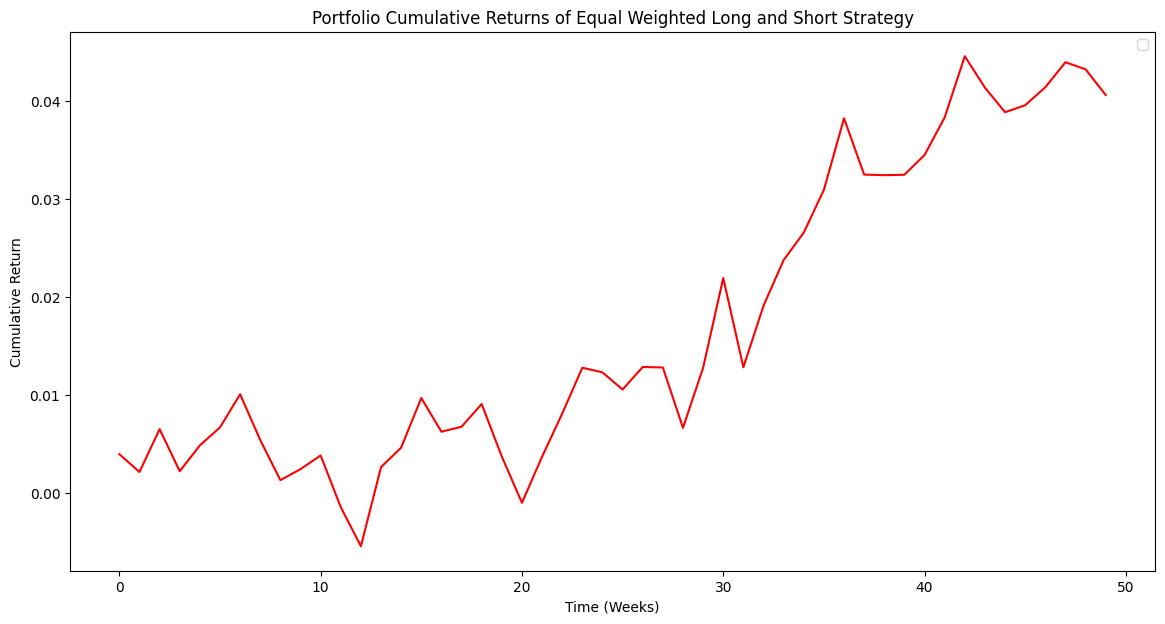

In [31]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

device = 'cuda'
model = conv3().cuda()

model.load_state_dict(torch.load('/kaggle/input/weight-lasttrained-0705/weight_lasttrained_0705.pth'))

# 计算所有股票的最长时间长度
max_length = max(len(data) for data in return_test_data)
print(max_length)

# 初始化投资组合累积收益数组和真实市场价格累积收益数组
portfolio_cumulative_returns = np.zeros(max_length)
portfolio_cumulative_actual_price_returns = np.zeros(max_length)
# print('portfolio_cumulative_returns shape:',portfolio_cumulative_returns.shape)

# 初始化每只股票的累积收益数组
cumulative_returns_per_stock = np.ones((len(stock_list), max_length))
# print('cumulative_returns_per_stock shape:',cumulative_returns_per_stock.shape)

# 初始化每只股票的每周收益数组和累计收益率
actual_price_returns_per_stock = np.zeros((len(stock_list), max_length))
cumulative_actual_price_returns_per_stock  = np.zeros((len(stock_list), max_length))

# 初始化投资组合的策略收益数组
portfolio_returns = np.zeros((max_length))

for i, stock_data in enumerate(image_test_data):
    testset = ImageDataset(f"test_x_{i}.npy",f"test_y_{i}.npy")
    batch_size = 1 # for testing
    test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=0,
                    pin_memory=True, drop_last=True)
    test_acc = evaluate_batch(model, test_loader, device)
    print(f'Stock code:{stock_list[i]}')
    test_matrix = get_confusion(model, test_loader, device)
    classes = ['Positive', 'Negative']

    y_true = []
    y_pred = []
    for iter, pack in enumerate(test_loader):
        data, target = pack[0].to(device), pack[1].to(device)
        targets = target.long()
        logits = model(data)
        _, pred = logits.max(1)
        y_true.append(target.item())
        y_pred.append(pred.item())

# ================================================20只股票等权重做多做空投资组合 累计收益 年化收益 夏普比率 =========================== 
    stock_returns_padded = np.pad(return_test_data[i], (0, max_length - len(return_test_data[i])), 'edge')
    actual_price_returns_per_stock[i,:] = stock_returns_padded
    y_pred_padded = np.pad(y_pred, (0, max_length - len(y_pred)), 'edge')
    
    
    cumulative_value = initial_investment
    for j in range(max_length):
        if y_pred_padded[j] == 1:  # 如果预测为1（做多）
            cumulative_actual_price_returns_per_stock[i,j] = cumulative_value * (1 + stock_returns_padded[j])
            cumulative_value *= (1 + stock_returns_padded[j])
        elif y_pred_padded[j] == 0:  # 如果预测为0（做空）
            cumulative_actual_price_returns_per_stock[i,j] = cumulative_value * (1 - stock_returns_padded[j])
            cumulative_value *= (1 - stock_returns_padded[j])  
        cumulative_returns_per_stock[i, j] = cumulative_value
        
# 计算等权投资组合的累积收益
for j in range(max_length):
    portfolio_cumulative_returns[j] = np.sum(cumulative_returns_per_stock[:,j], axis=0) / (len(stock_list)*initial_investment) - 1 
    portfolio_cumulative_actual_price_returns[j] = np.sum(cumulative_actual_price_returns_per_stock[:,j], axis=0) / (len(stock_list)*initial_investment) - 1 
    
    
    
# 反推投资组合每周期回报率
portfolio_per_week_returns = np.zeros((max_length))
portfolio_actual_price_per_week_returns = np.zeros((max_length))
for i in range(max_length - 1, 0, -1):
    portfolio_per_week_returns[i] = (portfolio_cumulative_returns[i] / portfolio_cumulative_returns[i-1]) - 1
    portfolio_actual_price_per_week_returns[i] = (portfolio_cumulative_actual_price_returns[i] / portfolio_cumulative_actual_price_returns[i-1]) - 1
# 将第一周的回报率设置为累积回报率
portfolio_per_week_returns[0] = portfolio_cumulative_returns[0]
portfolio_actual_price_per_week_returns[0] = portfolio_cumulative_actual_price_returns[0]
# print("Portfolio Strategy Weekly Returns:", portfolio_per_week_returns)
# print("Portfolio Actual Price Weekly Returns:", portfolio_actual_price_per_week_returns)




# 计算投资组合的年化收益
weeks_per_year = 52
howmanyyears = max_length / weeks_per_year  
annualized_return = (1 + portfolio_cumulative_returns[-1]) ** (1 / howmanyyears) - 1
# 计算夏普比率，假设无风险利率为0
annualized_volatility = np.std(portfolio_per_week_returns) * np.sqrt(weeks_per_year)
risk_free_rate = 0.0
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# 打印结果
print()
print('Portfolio strategy measure of equal weighted long and short strategy (each stock 1 unit initial investment)-------------------------------------------------')
print(f"Portfolio Cumulative Returns for whole test period: {portfolio_cumulative_returns[-1] * 100:.2f}%")
print(f"Portfolio Annualized Return: {annualized_return * 100:.2f}%")
print(f"Portfolio Sharpe Ratio: {sharpe_ratio:.2f}")

# 绘制等权投资组合的累积收益图
plt.figure(figsize=(14, 7))
# for i in range(len(stock_list)):
# plt.plot(portfolio_cumulative_actual_price_returns, label='Portfolio Actual Price Cumulative Return', color='black')
plt.plot(portfolio_cumulative_returns, color='red')

# 添加图例和标题
plt.legend()
plt.title('Portfolio Cumulative Returns of Equal Weighted Long and Short Strategy')
plt.xlabel('Time (Weeks)')
plt.ylabel('Cumulative Return')

# 显示图表
plt.show()